# Installation and Repository cloning

In [ ]:
!pip install adversarial-robustness-toolbox -U
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install git+https://github.com/RobustBench/robustbench.git
!pip install matplotlib
!pip install pillow
!pip install foolbox

Looking in indexes: https://download.pytorch.org/whl/cpu
  Cloning https://github.com/RobustBench/robustbench.git to c:\users\d7000ko\appdata\local\temp\pip-req-build-p8focw2i
  Resolved https://github.com/RobustBench/robustbench.git to commit 776bc95bb4167827fb102a32ac5aea62e46cfaab
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached autoattack-0.1-py3-none-any.whl


  Running command git clone --filter=blob:none --quiet https://github.com/RobustBench/robustbench.git 'C:\Users\d7000ko\AppData\Local\Temp\pip-req-build-p8focw2i'


## Import Libraries

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

import time
import matplotlib.pyplot as plt
import numpy as np

from art.estimators.classification import PyTorchClassifier
import json
import foolbox as fb

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load and Prepare CIFAR-10 Dataset

In [22]:
def load_dataset(dataset_split):
    # Load CIFAR-10 dataset using torchvision
    transform = transforms.Compose([
      transforms.ToTensor(),
                                 ])
    testset = datasets.CIFAR10(root='./data/cifar', train=False, download=True, transform=transform)

    # Truncated testset for experiments and ablations
    if isinstance(dataset_split, int):
        testset, _ = torch.utils.data.random_split(testset,
                                                          [dataset_split, len(testset) - dataset_split],
                                                          generator=torch.Generator().manual_seed(42))
    
    # Extract data and labels from torchvision dataset
    xtest = torch.stack([data[0] for data in testset])
    ytest = torch.tensor([data[1] for data in testset])

    return xtest, ytest

## Load and Prepare Adversarial Model

In [23]:
from robustbench.utils import load_model

model_name = 'Sehwag2021Proxy_R18'
net = load_model(model_name=model_name, dataset='cifar10', threat_model='L2')
net = torch.nn.DataParallel(net)

net.eval()
net.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

# Initialize PyTorchClassifier for ART toolbox as a wrapper
art_net = PyTorchClassifier(model=net,
                               loss=criterion,
                               optimizer=optimizer,
                               input_shape=(3, 32, 32),
                               nb_classes=10,
                               device_type=device,
                               clip_values=(0.0, 1.0))
fb_net = fb.PyTorchModel(net, bounds=(0.0, 1.0), device=device)

c:\Users\d7000ko\Desktop\Python\elastic_net_adversarial_attack\.venv\Lib\site-packages\robustbench\utils.py:165: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = t

## Function to Test Model Accuracy

In [24]:
def test_accuracy(model, xtest, ytest):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for i in range(len(xtest)):
            x = xtest[i].unsqueeze(0).to(device)
            y = ytest[i].unsqueeze(0).to(device)

            outputs = model(x)
            _, predicted = torch.max(outputs, 1)

            total += y.size(0)
            correct += (predicted==y).sum().item()

    accuracy = (correct / total) * 100
    print(f'\nAccuracy of the testset is: {accuracy:.3f}%\n')

## Adversarial Attacks

In [25]:
from art.attacks.evasion import (FastGradientMethod,
                                 ProjectedGradientDescentPyTorch,
                                 AutoProjectedGradientDescent,
                                 AutoAttack,
                                 CarliniL2Method,
                                 DeepFool,
                                 ElasticNet)
from autoattack import AutoAttack as original_AutoAttack

In [26]:
class AdversarialAttacks:
  def __init__(self, art_net, net, epsilon, eps_iter, norm, max_iterations_fast_attacks, max_iterations_slow_attacks):
    self.art_net = art_net
    self.epsilon = epsilon
    self.eps_iter = eps_iter
    self.norm = norm
    self.max_iterations_fast_attacks = max_iterations_fast_attacks
    self.max_iterations_slow_attacks = max_iterations_slow_attacks
    self.net = net

  def init_attacker(self, attack_type, **kwargs):
    if attack_type=='fast_gradient_method':
        return FastGradientMethod(self.art_net,
                                eps=self.epsilon,
                                eps_step=self.epsilon,
                                norm=self.norm,
                                **kwargs)
    elif attack_type=='projected_gradient_descent':
        return ProjectedGradientDescentPyTorch(self.art_net,
                                             eps=self.epsilon,
                                             eps_step=self.eps_iter,
                                             max_iter=self.max_iterations_fast_attacks,
                                             norm=self.norm,
                                             **kwargs)
    elif attack_type=='pgd_early_stopping':
        return ProjectedGradientDescentPyTorch(self.art_net,
                                             eps=self.epsilon,
                                             eps_step=self.eps_iter,
                                             max_iter=1,
                                             norm=self.norm,
                                             **kwargs)
    elif attack_type=='ART_AutoAttack':
        return AutoAttack(estimator=self.art_net,
                        eps=self.epsilon,
                        eps_step=self.eps_iter,
                        norm=self.norm)
    elif attack_type=='original_AutoAttack':
        return original_AutoAttack(net, 
                                   norm='L1', 
                                   eps=epsilon,
                                   device=device)
    elif attack_type=='auto_projected_gradient_descent':
        return AutoProjectedGradientDescent(estimator=self.art_net,
                                          eps=self.epsilon,
                                          eps_step=self.eps_iter,
                                          norm=self.norm,
                                          max_iter=self.max_iterations_fast_attacks,
                                          **kwargs)
    elif attack_type=='brendel_bethge':
        return fb.attacks.L1BrendelBethgeAttack(steps=self.max_iterations_fast_attacks)
    elif attack_type=='carlini_wagner_l2':
        return CarliniL2Method(self.art_net,
                               max_iter=self.max_iterations_slow_attacks,
                               **kwargs)
    elif attack_type=='deep_fool':
        return DeepFool(self.art_net,
                      max_iter=self.max_iterations_fast_attacks,
                      epsilon=self.eps_iter,
                      **kwargs)
    elif attack_type=='elastic_net':
        return ElasticNet(self.art_net,
                      max_iter=self.max_iterations_slow_attacks)
    elif attack_type=='elastic_net_L1_rule':
        return ElasticNet(self.art_net,
                      max_iter=self.max_iterations_slow_attacks,
                      decision_rule='L1')
    elif attack_type=='elastic_net_L1_rule_higher_beta':
        return ElasticNet(self.art_net,
                      max_iter=self.max_iterations_slow_attacks,
                      decision_rule='L1',
                      beta=0.01)
    else:
        raise ValueError(f'Attack type "{attack_type}" not supported!')

## Plug-in Function for Adversarial Attack with Early Stopping

In [27]:
def attack_with_early_stopping(art_net, x, y, PGD_iterations, attacker):
    label_flipped = False

    for j in range(PGD_iterations):
        adv_inputs = attacker.generate(x, y.numpy(), verbose=False)

        outputs = art_net.predict(adv_inputs)
        _, predicted = torch.max(torch.tensor(outputs).data, 1)
        label_flipped = bool(predicted.item() != int(y.item()))

        if label_flipped:
            print(f'\tIterations for successful iterative attack: {j+1}')
            break
        
        x = adv_inputs.copy()
            
    return adv_inputs

## Function for Adversarial Distance calculation (attack methods)

In [28]:
def calculation(art_net, fb_net, net, xtest, ytest, epsilon, eps_iter, norm, max_iterations_slow_attacks, max_iterations_fast_attacks, attack_type, verbose: bool = False):

    distance_list, runtime_list = [], []
    art_net.model.to(device)
    net.to(device)
    
    xtest = xtest.to(device)
    ytest = ytest.to(device)
    
    attacks = AdversarialAttacks(art_net=art_net,
                                 net = net,
                          epsilon=epsilon,
                          eps_iter=eps_iter,
                          norm=norm,
                          max_iterations_fast_attacks=max_iterations_fast_attacks,
                          max_iterations_slow_attacks=max_iterations_slow_attacks)
    attacker = attacks.init_attacker(attack_type)

    robust_predictions = 0
    attack_successes = 0
    clean_correct = 0

    for i, x in enumerate(xtest):

        x = x.unsqueeze(0)
        y = ytest[i].unsqueeze(0)

        outputs = art_net.predict(x)
        _, clean_predicted = torch.max(torch.tensor(outputs).data, 1)
            
        if int(clean_predicted.item()) != int(y.item()):
            print('Misclassified input. Not attacking.')
            distance_list.append(False)
            runtime_list.append(False)
            continue        

        clean_correct += 1

        start_time = time.time()

        if attack_type == 'pgd_early_stopping':
            x_adversarial = attack_with_early_stopping(art_net=art_net,
                                                                x=x.numpy(),
                                                                y=y,
                                                                PGD_iterations=max_iterations_fast_attacks,
                                                                attacker=attacker)
            x_adversarial = torch.from_numpy(x_adversarial)
        elif attack_type == 'brendel_bethge':
            _, x_adversarial, _ = attacker(fb_net, x, y, epsilons=[epsilon])
            x_adversarial = x_adversarial[0]
        elif attack_type == 'original_AutoAttack':
            x_adversarial = attacker.run_standard_evaluation(x, y)
            x_adversarial = x_adversarial
        else:             
            x_adversarial = attacker.generate(x.numpy(), y.numpy())
            x_adversarial = torch.from_numpy(x_adversarial)
        
        end_time = time.time()
        runtime = end_time - start_time
        runtime_list.append(runtime)

        # Adversarial accuracy calculation
        output_adversarial = art_net.predict(x_adversarial)
        _, predicted_adversarial = torch.max(torch.tensor(output_adversarial).data, 1)

        # Adversarial distance calculation: if no AE found, save epsilon as distance, otherwise save the distance
        if int(predicted_adversarial.item()) == int(y.item()):
            robust_predictions += 1
            distance = epsilon
            distance_list.append(distance)
            if verbose:
                print(f'Image {i}: No adversarial example found.')
        else:
            distance = torch.norm((x - x_adversarial), p=float(norm))
            robust_predictions += (round(distance.item(), 2) > epsilon) 
            attack_successes += (round(distance.item(), 2) <= epsilon) 
            distance_list.append(min(distance.item(), epsilon)) #appending epsilon if distance of adversarial example is higher

        if verbose:
            print(f'Image {i}\t\tAdversarial_distance: {distance:.5f}\t\tRuntime: {runtime:5f} seconds')
        if (i + 1) % 20 == 0:
            print(f'{i+1} images done. Current Adversarial Accuracy: {robust_predictions/(i+1)}%')

    adversarial_accuracy = (robust_predictions / len(xtest)) * 100
    attack_success_rate = (attack_successes / clean_correct) * 100
    print(f'\nAdversarial accuracy: {adversarial_accuracy}%\n')

    return distance_list, runtime_list, adversarial_accuracy, attack_success_rate

## Parameters

In [29]:
norm = 1  # 1, 2, np.inf
max_iterations_fast_attacks = 100
max_iterations_slow_attacks = 20
eps_iter = 0.15
epsilon = 12

## Load the dataset

In [30]:
splitsize = 50      # full, int: splitsize
xtest, ytest = load_dataset(dataset_split=splitsize)

Files already downloaded and verified


## Test Accuracy

In [ ]:
test_accuracy(net, xtest, ytest)


Accuracy of the testset is: 92.000%

None


# Experiments

In [32]:
attack_types = ['fast_gradient_method', #bounded-full
                'projected_gradient_descent', #bounded-full
                #'pgd_early_stopping', #not-bounded
                'auto_projected_gradient_descent', #bounded-full
                'deep_fool', #not-bounded
                'brendel_bethge', #bounded-min
                'carlini_wagner_l2', #not-bounded
                'elastic_net', #not-bounded
                'elastic_net_L1_rule', #not-bounded
                'elastic_net_L1_rule_higher_beta', #not-bounded
                #'ART_AutoAttack', #bounded-full
                'original_AutoAttack', #bounded-full
                ]

results_dict = {}

for attack_type in attack_types:
    results_dict[attack_type] = {}
    print(f'\t\t-------------------------- Processing Attack: {attack_type} --------------------------\n')
    results_dict[attack_type]["adversarial_distance"], results_dict[attack_type]["runtime"], results_dict[attack_type]["adversarial_accuracy"] , results_dict[attack_type]["attack_success_rate"] = calculation(
                                                        art_net=art_net,
                                                        fb_net=fb_net,
                                                        net = net,
                                                        xtest=xtest,
                                                        ytest=ytest,
                                                        epsilon=epsilon,
                                                        eps_iter=eps_iter,
                                                        norm=norm,
                                                        max_iterations_fast_attacks=max_iterations_fast_attacks,
                                                        max_iterations_slow_attacks=max_iterations_slow_attacks,
                                                        attack_type=attack_type,
                                                        verbose=True)
    
    mean_value = np.mean([x for x in results_dict[attack_type]["adversarial_distance"] if x is not None])

    print(f'\nMean adversarial distance for {attack_type}: {mean_value:.5f} with total runtime: {sum(results_dict[attack_type]["runtime"]): .5f} seconds\n')

		-------------------------- Processing Attack: fast_gradient_method --------------------------

Image 0: No adversarial example found.
Image 0		Adversarial_distance: 12.00000		Runtime: 0.233120 seconds
Image 1: No adversarial example found.
Image 1		Adversarial_distance: 12.00000		Runtime: 0.090647 seconds
Image 2: No adversarial example found.
Image 2		Adversarial_distance: 12.00000		Runtime: 0.094251 seconds
Image 3: No adversarial example found.
Image 3		Adversarial_distance: 12.00000		Runtime: 0.099764 seconds
Image 4: No adversarial example found.
Image 4		Adversarial_distance: 12.00000		Runtime: 0.183489 seconds
Image 5: No adversarial example found.
Image 5		Adversarial_distance: 12.00000		Runtime: 0.117792 seconds
Image 6: No adversarial example found.
Image 6		Adversarial_distance: 12.00000		Runtime: 0.282751 seconds
Image 7: No adversarial example found.
Image 7		Adversarial_distance: 12.00000		Runtime: 0.086231 seconds
Image 8: No adversarial example found.
Image 8		Adversa

Image 0: No adversarial example found.
Image 0		Adversarial_distance: 12.00000		Runtime: 9.969798 seconds


Image 1: No adversarial example found.
Image 1		Adversarial_distance: 12.00000		Runtime: 10.505865 seconds


Image 2: No adversarial example found.
Image 2		Adversarial_distance: 12.00000		Runtime: 11.822675 seconds


Image 3: No adversarial example found.
Image 3		Adversarial_distance: 12.00000		Runtime: 9.417459 seconds


Image 4		Adversarial_distance: 1.44216		Runtime: 10.022252 seconds


Image 5: No adversarial example found.
Image 5		Adversarial_distance: 12.00000		Runtime: 7.579697 seconds


Image 6: No adversarial example found.
Image 6		Adversarial_distance: 12.00000		Runtime: 7.448715 seconds


Image 7: No adversarial example found.
Image 7		Adversarial_distance: 12.00000		Runtime: 6.916567 seconds


Image 8: No adversarial example found.
Image 8		Adversarial_distance: 12.00000		Runtime: 7.445310 seconds


Image 9: No adversarial example found.
Image 9		Adversarial_distance: 12.00000		Runtime: 6.515837 seconds


Image 10: No adversarial example found.
Image 10		Adversarial_distance: 12.00000		Runtime: 6.473083 seconds


Image 11: No adversarial example found.
Image 11		Adversarial_distance: 12.00000		Runtime: 6.959038 seconds


Image 12: No adversarial example found.
Image 12		Adversarial_distance: 12.00000		Runtime: 6.826565 seconds


Image 13: No adversarial example found.
Image 13		Adversarial_distance: 12.00000		Runtime: 6.650696 seconds


Image 14: No adversarial example found.
Image 14		Adversarial_distance: 12.00000		Runtime: 6.320816 seconds


Image 15: No adversarial example found.
Image 15		Adversarial_distance: 12.00000		Runtime: 6.501318 seconds


Image 16		Adversarial_distance: 1.48137		Runtime: 7.038714 seconds


Image 17: No adversarial example found.
Image 17		Adversarial_distance: 12.00000		Runtime: 6.622128 seconds


Image 18: No adversarial example found.
Image 18		Adversarial_distance: 12.00000		Runtime: 7.333807 seconds


Image 19: No adversarial example found.
Image 19		Adversarial_distance: 12.00000		Runtime: 6.502198 seconds
20 images done. Current Adversarial Accuracy: 0.9%


Image 20: No adversarial example found.
Image 20		Adversarial_distance: 12.00000		Runtime: 6.729912 seconds


Image 21: No adversarial example found.
Image 21		Adversarial_distance: 12.00000		Runtime: 6.027560 seconds


Image 22: No adversarial example found.
Image 22		Adversarial_distance: 12.00000		Runtime: 6.890779 seconds


Image 23: No adversarial example found.
Image 23		Adversarial_distance: 12.00000		Runtime: 6.630351 seconds


Image 24: No adversarial example found.
Image 24		Adversarial_distance: 12.00000		Runtime: 7.337922 seconds


Image 25: No adversarial example found.
Image 25		Adversarial_distance: 12.00000		Runtime: 7.116436 seconds


Image 26: No adversarial example found.
Image 26		Adversarial_distance: 12.00000		Runtime: 6.809631 seconds


Image 27: No adversarial example found.
Image 27		Adversarial_distance: 12.00000		Runtime: 7.278866 seconds


Image 28: No adversarial example found.
Image 28		Adversarial_distance: 12.00000		Runtime: 6.526242 seconds


Image 29: No adversarial example found.
Image 29		Adversarial_distance: 12.00000		Runtime: 5.638908 seconds


Image 30: No adversarial example found.
Image 30		Adversarial_distance: 12.00000		Runtime: 6.329655 seconds


Image 31: No adversarial example found.
Image 31		Adversarial_distance: 12.00000		Runtime: 5.831031 seconds
Misclassified input. Not attacking.


Image 33: No adversarial example found.
Image 33		Adversarial_distance: 12.00000		Runtime: 5.845051 seconds


Image 34: No adversarial example found.
Image 34		Adversarial_distance: 12.00000		Runtime: 5.706182 seconds
Misclassified input. Not attacking.


Image 36: No adversarial example found.
Image 36		Adversarial_distance: 12.00000		Runtime: 6.094145 seconds


Image 37: No adversarial example found.
Image 37		Adversarial_distance: 12.00000		Runtime: 6.595366 seconds


Image 38		Adversarial_distance: 5.21863		Runtime: 6.742517 seconds
Misclassified input. Not attacking.


Image 40: No adversarial example found.
Image 40		Adversarial_distance: 12.00000		Runtime: 6.982578 seconds


Image 41: No adversarial example found.
Image 41		Adversarial_distance: 12.00000		Runtime: 7.025014 seconds


Image 42: No adversarial example found.
Image 42		Adversarial_distance: 12.00000		Runtime: 7.045245 seconds


Image 43: No adversarial example found.
Image 43		Adversarial_distance: 12.00000		Runtime: 7.148038 seconds


Image 44: No adversarial example found.
Image 44		Adversarial_distance: 12.00000		Runtime: 7.186926 seconds
Misclassified input. Not attacking.


Image 46: No adversarial example found.
Image 46		Adversarial_distance: 12.00000		Runtime: 6.866314 seconds


Image 47: No adversarial example found.
Image 47		Adversarial_distance: 12.00000		Runtime: 6.898915 seconds


Image 48: No adversarial example found.
Image 48		Adversarial_distance: 12.00000		Runtime: 6.927431 seconds


Image 49: No adversarial example found.
Image 49		Adversarial_distance: 12.00000		Runtime: 5.981104 seconds

Adversarial accuracy: 86.0%


Mean adversarial distance for projected_gradient_descent: 10.48284 with total runtime:  327.06466 seconds

		-------------------------- Processing Attack: auto_projected_gradient_descent --------------------------



AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]






















































AutoPGD - restart:  20%|██        | 1/5 [00:08<00:34,  8.68s/it]



















































AutoPGD - restart:  40%|████      | 2/5 [00:17<00:25,  8.66s/it]



















































AutoPGD - restart:  60%|██████    | 3/5 [00:25<00:17,  8.50s/it]



















































AutoPGD - restart:  80%|████████  | 4/5 [00:33<00:08,  8.39s/it]



















































AutoPGD - restart: 100%|██████████| 5/5 [00:42<00:00,  8.55s/it]


Image 0: No adversarial example found.
Image 0		Adversarial_distance: 12.00000		Runtime: 42.755743 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]



















































AutoPGD - restart:  20%|██        | 1/5 [00:08<00:35,  8.79s/it]





























































AutoPGD - restart:  40%|████      | 2/5 [00:18<00:27,  9.31s/it]













































































AutoPGD - restart:  60%|██████    | 3/5 [00:29<00:19,  9.94s/it]


























































AutoPGD - restart:  80%|████████  | 4/5 [00:38<00:09,  9.86s/it]































































AutoPGD - restart: 100%|██████████| 5/5 [00:48<00:00,  9.76s/it]


Image 1: No adversarial example found.
Image 1		Adversarial_distance: 12.00000		Runtime: 48.806912 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]






















































AutoPGD - restart:  20%|██        | 1/5 [00:09<00:37,  9.39s/it]


































































AutoPGD - restart:  40%|████      | 2/5 [00:19<00:28,  9.62s/it]




















































AutoPGD - restart:  60%|██████    | 3/5 [00:28<00:19,  9.54s/it]

























































AutoPGD - restart:  80%|████████  | 4/5 [00:38<00:09,  9.56s/it]























































AutoPGD - restart: 100%|██████████| 5/5 [00:47<00:00,  9.55s/it]


Image 2: No adversarial example found.
Image 2		Adversarial_distance: 12.00000		Runtime: 47.731054 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]




























































AutoPGD - restart:  20%|██        | 1/5 [00:09<00:38,  9.58s/it]



















































AutoPGD - restart:  40%|████      | 2/5 [00:17<00:26,  8.79s/it]



















































AutoPGD - restart:  60%|██████    | 3/5 [00:26<00:17,  8.53s/it]






















































AutoPGD - restart:  80%|████████  | 4/5 [00:35<00:08,  8.71s/it]




















































AutoPGD - restart: 100%|██████████| 5/5 [00:44<00:00,  8.83s/it]


Image 3: No adversarial example found.
Image 3		Adversarial_distance: 12.00000		Runtime: 44.138634 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]



























































AutoPGD - restart:  20%|██        | 1/5 [00:09<00:39,  9.92s/it]


Image 4		Adversarial_distance: 12.00000		Runtime: 9.919899 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]






























































AutoPGD - restart:  20%|██        | 1/5 [00:10<00:40, 10.13s/it]


























































AutoPGD - restart:  40%|████      | 2/5 [00:20<00:30, 10.10s/it]





























































AutoPGD - restart:  60%|██████    | 3/5 [00:30<00:20, 10.08s/it]








































































AutoPGD - restart:  80%|████████  | 4/5 [00:40<00:10, 10.21s/it]































































AutoPGD - restart: 100%|██████████| 5/5 [00:50<00:00, 10.18s/it]


Image 5: No adversarial example found.
Image 5		Adversarial_distance: 12.00000		Runtime: 50.892498 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]


































































AutoPGD - restart:  20%|██        | 1/5 [00:10<00:40, 10.02s/it]





































































AutoPGD - restart:  40%|████      | 2/5 [00:20<00:30, 10.17s/it]






















































AutoPGD - restart:  60%|██████    | 3/5 [00:29<00:19,  9.66s/it]























































AutoPGD - restart:  80%|████████  | 4/5 [00:38<00:09,  9.57s/it]





















































AutoPGD - restart: 100%|██████████| 5/5 [00:48<00:00,  9.61s/it]


Image 6: No adversarial example found.
Image 6		Adversarial_distance: 12.00000		Runtime: 48.040207 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

























































AutoPGD - restart:  20%|██        | 1/5 [00:09<00:39,  9.89s/it]





















































AutoPGD - restart:  40%|████      | 2/5 [00:19<00:29,  9.72s/it]


























































AutoPGD - restart:  60%|██████    | 3/5 [00:29<00:19,  9.70s/it]



















































AutoPGD - restart:  80%|████████  | 4/5 [00:37<00:09,  9.34s/it]




















































AutoPGD - restart: 100%|██████████| 5/5 [00:46<00:00,  9.36s/it]


Image 7: No adversarial example found.
Image 7		Adversarial_distance: 12.00000		Runtime: 46.792996 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]




































































AutoPGD - restart:  20%|██        | 1/5 [00:10<00:41, 10.37s/it]




















































AutoPGD - restart:  40%|████      | 2/5 [00:19<00:29,  9.68s/it]



















































AutoPGD - restart:  60%|██████    | 3/5 [00:28<00:18,  9.39s/it]





















































AutoPGD - restart:  80%|████████  | 4/5 [00:38<00:09,  9.54s/it]



























































AutoPGD - restart: 100%|██████████| 5/5 [00:48<00:00,  9.69s/it]


Image 8: No adversarial example found.
Image 8		Adversarial_distance: 12.00000		Runtime: 48.440741 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]





























































AutoPGD - restart:  20%|██        | 1/5 [00:10<00:40, 10.24s/it]







































































AutoPGD - restart:  40%|████      | 2/5 [00:20<00:31, 10.37s/it]




































































AutoPGD - restart:  60%|██████    | 3/5 [00:31<00:20, 10.37s/it]



































































AutoPGD - restart:  80%|████████  | 4/5 [00:41<00:10, 10.37s/it]





























































AutoPGD - restart: 100%|██████████| 5/5 [00:51<00:00, 10.32s/it]


Image 9: No adversarial example found.
Image 9		Adversarial_distance: 12.00000		Runtime: 51.583961 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]










































































AutoPGD - restart:  20%|██        | 1/5 [00:10<00:42, 10.60s/it]
























































AutoPGD - restart:  40%|████      | 2/5 [00:20<00:30, 10.21s/it]






















































AutoPGD - restart:  60%|██████    | 3/5 [00:30<00:19,  9.89s/it]














































































AutoPGD - restart:  80%|████████  | 4/5 [00:41<00:10, 10.35s/it]






















































AutoPGD - restart: 100%|██████████| 5/5 [00:50<00:00, 10.18s/it]


Image 10: No adversarial example found.
Image 10		Adversarial_distance: 12.00000		Runtime: 50.921395 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]












































































AutoPGD - restart:  20%|██        | 1/5 [00:10<00:42, 10.70s/it]






























































AutoPGD - restart:  40%|████      | 2/5 [00:20<00:31, 10.39s/it]
































































AutoPGD - restart:  60%|██████    | 3/5 [00:30<00:20, 10.26s/it]






















































AutoPGD - restart:  80%|████████  | 4/5 [00:40<00:09,  9.94s/it]



















































AutoPGD - restart: 100%|██████████| 5/5 [00:49<00:00,  9.92s/it]


Image 11: No adversarial example found.
Image 11		Adversarial_distance: 12.00000		Runtime: 49.609459 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]






























































AutoPGD - restart:  20%|██        | 1/5 [00:09<00:39,  9.97s/it]
































































AutoPGD - restart:  40%|████      | 2/5 [00:20<00:30, 10.01s/it]
































































AutoPGD - restart:  60%|██████    | 3/5 [00:30<00:20, 10.17s/it]













































































AutoPGD - restart:  80%|████████  | 4/5 [00:41<00:10, 10.40s/it]















































































AutoPGD - restart: 100%|██████████| 5/5 [00:51<00:00, 10.40s/it]


Image 12: No adversarial example found.
Image 12		Adversarial_distance: 12.00000		Runtime: 51.988575 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]
































































AutoPGD - restart:  20%|██        | 1/5 [00:10<00:40, 10.15s/it]























































AutoPGD - restart:  40%|████      | 2/5 [00:19<00:29,  9.70s/it]























































AutoPGD - restart:  60%|██████    | 3/5 [00:29<00:19,  9.68s/it]

























































AutoPGD - restart:  80%|████████  | 4/5 [00:38<00:09,  9.70s/it]





















































AutoPGD - restart: 100%|██████████| 5/5 [00:48<00:00,  9.68s/it]


Image 13: No adversarial example found.
Image 13		Adversarial_distance: 12.00000		Runtime: 48.392013 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]




















































































AutoPGD - restart:  20%|██        | 1/5 [00:10<00:43, 10.81s/it]





























































AutoPGD - restart:  40%|████      | 2/5 [00:20<00:30, 10.16s/it]
























































AutoPGD - restart:  60%|██████    | 3/5 [00:29<00:19,  9.84s/it]






























































AutoPGD - restart:  80%|████████  | 4/5 [00:39<00:09,  9.85s/it]





























































AutoPGD - restart: 100%|██████████| 5/5 [00:49<00:00,  9.96s/it]


Image 14: No adversarial example found.
Image 14		Adversarial_distance: 12.00000		Runtime: 49.809298 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]
















































































AutoPGD - restart:  20%|██        | 1/5 [00:10<00:43, 10.77s/it]



































































AutoPGD - restart:  40%|████      | 2/5 [00:21<00:31, 10.58s/it]
































































AutoPGD - restart:  60%|██████    | 3/5 [00:31<00:20, 10.36s/it]





















































AutoPGD - restart:  80%|████████  | 4/5 [00:40<00:10, 10.08s/it]





























































AutoPGD - restart: 100%|██████████| 5/5 [00:51<00:00, 10.22s/it]


Image 15: No adversarial example found.
Image 15		Adversarial_distance: 12.00000		Runtime: 51.121948 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]


































































AutoPGD - restart:  20%|██        | 1/5 [00:10<00:41, 10.38s/it]


Image 16		Adversarial_distance: 12.00002		Runtime: 10.386308 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]














































































AutoPGD - restart:  20%|██        | 1/5 [00:11<00:44, 11.01s/it]








































































AutoPGD - restart:  40%|████      | 2/5 [00:21<00:32, 10.68s/it]












































































AutoPGD - restart:  60%|██████    | 3/5 [00:32<00:21, 10.68s/it]




































































AutoPGD - restart:  80%|████████  | 4/5 [00:42<00:10, 10.58s/it]




























































AutoPGD - restart: 100%|██████████| 5/5 [00:52<00:00, 10.55s/it]


Image 17: No adversarial example found.
Image 17		Adversarial_distance: 12.00000		Runtime: 52.770923 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]











































































AutoPGD - restart:  20%|██        | 1/5 [00:10<00:43, 10.76s/it]

















































































AutoPGD - restart:  40%|████      | 2/5 [00:21<00:32, 10.81s/it]












































































AutoPGD - restart:  60%|██████    | 3/5 [00:32<00:21, 10.71s/it]






























































AutoPGD - restart:  80%|████████  | 4/5 [00:42<00:10, 10.49s/it]














































































AutoPGD - restart: 100%|██████████| 5/5 [00:53<00:00, 10.60s/it]


Image 18: No adversarial example found.
Image 18		Adversarial_distance: 12.00000		Runtime: 53.007256 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]




















































































AutoPGD - restart:  20%|██        | 1/5 [00:11<00:44, 11.15s/it]




























































AutoPGD - restart:  40%|████      | 2/5 [00:21<00:31, 10.57s/it]















































































AutoPGD - restart:  60%|██████    | 3/5 [00:32<00:21, 10.83s/it]



































































AutoPGD - restart:  80%|████████  | 4/5 [00:42<00:10, 10.61s/it]

































































AutoPGD - restart: 100%|██████████| 5/5 [00:53<00:00, 10.61s/it]


Image 19: No adversarial example found.
Image 19		Adversarial_distance: 12.00000		Runtime: 53.045259 seconds
20 images done. Current Adversarial Accuracy: 0.9%


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]















































































AutoPGD - restart:  20%|██        | 1/5 [00:10<00:43, 10.78s/it]






































































AutoPGD - restart:  40%|████      | 2/5 [00:21<00:32, 10.69s/it]

































































AutoPGD - restart:  60%|██████    | 3/5 [00:31<00:20, 10.43s/it]










































































AutoPGD - restart:  80%|████████  | 4/5 [00:42<00:10, 10.48s/it]








































































AutoPGD - restart: 100%|██████████| 5/5 [00:52<00:00, 10.53s/it]


Image 20: No adversarial example found.
Image 20		Adversarial_distance: 12.00000		Runtime: 52.643970 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

















































































AutoPGD - restart:  20%|██        | 1/5 [00:10<00:42, 10.68s/it]




















































































AutoPGD - restart:  40%|████      | 2/5 [00:21<00:32, 10.88s/it]


























































AutoPGD - restart:  60%|██████    | 3/5 [00:31<00:21, 10.61s/it]









































































AutoPGD - restart:  80%|████████  | 4/5 [00:42<00:10, 10.61s/it]











































































AutoPGD - restart: 100%|██████████| 5/5 [00:53<00:00, 10.68s/it]


Image 21: No adversarial example found.
Image 21		Adversarial_distance: 12.00000		Runtime: 53.385576 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]















































































AutoPGD - restart:  20%|██        | 1/5 [00:10<00:42, 10.73s/it]














































































AutoPGD - restart:  40%|████      | 2/5 [00:21<00:32, 10.86s/it]








































































AutoPGD - restart:  60%|██████    | 3/5 [00:32<00:21, 10.82s/it]














































































AutoPGD - restart:  80%|████████  | 4/5 [00:43<00:10, 10.79s/it]




















































































AutoPGD - restart: 100%|██████████| 5/5 [00:54<00:00, 10.84s/it]


Image 22: No adversarial example found.
Image 22		Adversarial_distance: 12.00000		Runtime: 54.213500 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]


















































































AutoPGD - restart:  20%|██        | 1/5 [00:11<00:44, 11.08s/it]






















































































AutoPGD - restart:  40%|████      | 2/5 [00:22<00:33, 11.01s/it]























































































AutoPGD - restart:  60%|██████    | 3/5 [00:33<00:22, 11.04s/it]











































































AutoPGD - restart:  80%|████████  | 4/5 [00:43<00:10, 10.91s/it]











































































AutoPGD - restart: 100%|██████████| 5/5 [00:54<00:00, 10.93s/it]


Image 23: No adversarial example found.
Image 23		Adversarial_distance: 12.00000		Runtime: 54.634876 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]





















































































AutoPGD - restart:  20%|██        | 1/5 [00:11<00:45, 11.28s/it]

















































































AutoPGD - restart:  40%|████      | 2/5 [00:22<00:33, 11.08s/it]













































































AutoPGD - restart:  60%|██████    | 3/5 [00:32<00:21, 10.94s/it]














































































AutoPGD - restart:  80%|████████  | 4/5 [00:43<00:10, 10.89s/it]






































































AutoPGD - restart: 100%|██████████| 5/5 [00:54<00:00, 10.89s/it]


Image 24: No adversarial example found.
Image 24		Adversarial_distance: 12.00000		Runtime: 54.474440 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]















































































AutoPGD - restart:  20%|██        | 1/5 [00:10<00:43, 10.82s/it]




















































































AutoPGD - restart:  40%|████      | 2/5 [00:21<00:32, 10.95s/it]
















































































AutoPGD - restart:  60%|██████    | 3/5 [00:32<00:21, 10.89s/it]









































































AutoPGD - restart:  80%|████████  | 4/5 [00:43<00:10, 10.78s/it]

















































































AutoPGD - restart: 100%|██████████| 5/5 [00:54<00:00, 10.85s/it]


Image 25: No adversarial example found.
Image 25		Adversarial_distance: 12.00000		Runtime: 54.239383 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]





















































































AutoPGD - restart:  20%|██        | 1/5 [00:11<00:44, 11.11s/it]































































































AutoPGD - restart:  40%|████      | 2/5 [00:25<00:38, 12.76s/it]





























































































AutoPGD - restart:  60%|██████    | 3/5 [00:38<00:26, 13.03s/it]


































































































AutoPGD - restart:  80%|████████  | 4/5 [00:51<00:13, 13.14s/it]















































































AutoPGD - restart: 100%|██████████| 5/5 [01:02<00:00, 12.48s/it]


Image 26: No adversarial example found.
Image 26		Adversarial_distance: 12.00000		Runtime: 62.423088 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]
























































































AutoPGD - restart:  20%|██        | 1/5 [00:10<00:43, 10.99s/it]



















































































AutoPGD - restart:  40%|████      | 2/5 [00:22<00:33, 11.06s/it]
















































































AutoPGD - restart:  60%|██████    | 3/5 [00:32<00:21, 10.87s/it]















































































AutoPGD - restart:  80%|████████  | 4/5 [00:43<00:10, 10.82s/it]




















































































AutoPGD - restart: 100%|██████████| 5/5 [00:54<00:00, 10.86s/it]


Image 27: No adversarial example found.
Image 27		Adversarial_distance: 12.00000		Runtime: 54.311505 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]























































































AutoPGD - restart:  20%|██        | 1/5 [00:10<00:43, 10.97s/it]


















































































AutoPGD - restart:  40%|████      | 2/5 [00:21<00:32, 10.83s/it]
















































































AutoPGD - restart:  60%|██████    | 3/5 [00:32<00:21, 10.85s/it]














































































AutoPGD - restart:  80%|████████  | 4/5 [00:43<00:10, 10.86s/it]


















































































AutoPGD - restart: 100%|██████████| 5/5 [00:54<00:00, 10.87s/it]


Image 28: No adversarial example found.
Image 28		Adversarial_distance: 12.00000		Runtime: 54.332493 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]



















































































AutoPGD - restart:  20%|██        | 1/5 [00:10<00:43, 10.97s/it]

















































































AutoPGD - restart:  40%|████      | 2/5 [00:21<00:32, 10.91s/it]











































































AutoPGD - restart:  60%|██████    | 3/5 [00:32<00:21, 10.78s/it]




































































AutoPGD - restart:  80%|████████  | 4/5 [00:43<00:10, 10.70s/it]
















































































AutoPGD - restart: 100%|██████████| 5/5 [00:53<00:00, 10.75s/it]


Image 29: No adversarial example found.
Image 29		Adversarial_distance: 12.00000		Runtime: 53.771067 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]























































































AutoPGD - restart:  20%|██        | 1/5 [00:11<00:44, 11.05s/it]















































































AutoPGD - restart:  40%|████      | 2/5 [00:21<00:32, 10.93s/it]



















































































AutoPGD - restart:  60%|██████    | 3/5 [00:32<00:21, 10.88s/it]


















































































AutoPGD - restart:  80%|████████  | 4/5 [00:43<00:10, 10.90s/it]



















































































AutoPGD - restart: 100%|██████████| 5/5 [00:54<00:00, 10.89s/it]


Image 30: No adversarial example found.
Image 30		Adversarial_distance: 12.00000		Runtime: 54.442851 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]




















































































AutoPGD - restart:  20%|██        | 1/5 [00:10<00:43, 10.88s/it]














































































AutoPGD - restart:  40%|████      | 2/5 [00:21<00:31, 10.61s/it]

















































































AutoPGD - restart:  60%|██████    | 3/5 [00:32<00:21, 10.68s/it]








































































AutoPGD - restart:  80%|████████  | 4/5 [00:42<00:10, 10.59s/it]










































































AutoPGD - restart: 100%|██████████| 5/5 [00:53<00:00, 10.61s/it]


Image 31: No adversarial example found.
Image 31		Adversarial_distance: 12.00000		Runtime: 53.058799 seconds
Misclassified input. Not attacking.


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]













































































AutoPGD - restart:  20%|██        | 1/5 [00:10<00:42, 10.71s/it]






































































AutoPGD - restart:  40%|████      | 2/5 [00:21<00:32, 10.67s/it]

































































AutoPGD - restart:  60%|██████    | 3/5 [00:31<00:21, 10.54s/it]






































































AutoPGD - restart:  80%|████████  | 4/5 [00:42<00:10, 10.48s/it]














































































AutoPGD - restart: 100%|██████████| 5/5 [00:53<00:00, 10.61s/it]


Image 33: No adversarial example found.
Image 33		Adversarial_distance: 12.00000		Runtime: 53.071432 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]












































































AutoPGD - restart:  20%|██        | 1/5 [00:10<00:42, 10.72s/it]









































































AutoPGD - restart:  40%|████      | 2/5 [00:21<00:31, 10.59s/it]



































































AutoPGD - restart:  60%|██████    | 3/5 [00:31<00:21, 10.54s/it]

































































AutoPGD - restart:  80%|████████  | 4/5 [00:42<00:10, 10.50s/it]












































































AutoPGD - restart: 100%|██████████| 5/5 [00:52<00:00, 10.59s/it]


Image 34: No adversarial example found.
Image 34		Adversarial_distance: 12.00000		Runtime: 52.950871 seconds
Misclassified input. Not attacking.


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]







































































AutoPGD - restart:  20%|██        | 1/5 [00:10<00:41, 10.30s/it]

















































































AutoPGD - restart:  40%|████      | 2/5 [00:21<00:32, 10.68s/it]






































































AutoPGD - restart:  60%|██████    | 3/5 [00:31<00:21, 10.61s/it]














































































AutoPGD - restart:  80%|████████  | 4/5 [00:42<00:10, 10.61s/it]











































































AutoPGD - restart: 100%|██████████| 5/5 [00:53<00:00, 10.64s/it]


Image 36: No adversarial example found.
Image 36		Adversarial_distance: 12.00000		Runtime: 53.189279 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]


















































































AutoPGD - restart:  20%|██        | 1/5 [00:10<00:43, 10.96s/it]








































































AutoPGD - restart:  40%|████      | 2/5 [00:21<00:32, 10.76s/it]






































































AutoPGD - restart:  60%|██████    | 3/5 [00:31<00:21, 10.57s/it]













































































AutoPGD - restart:  80%|████████  | 4/5 [00:42<00:10, 10.65s/it]













































































AutoPGD - restart: 100%|██████████| 5/5 [00:53<00:00, 10.68s/it]


Image 37: No adversarial example found.
Image 37		Adversarial_distance: 12.00000		Runtime: 53.426974 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]


















































































AutoPGD - restart:  20%|██        | 1/5 [00:11<00:44, 11.07s/it]


Image 38		Adversarial_distance: 12.00003		Runtime: 11.075135 seconds
Misclassified input. Not attacking.


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]


















































































AutoPGD - restart:  20%|██        | 1/5 [00:10<00:43, 10.79s/it]














































































AutoPGD - restart:  40%|████      | 2/5 [00:21<00:32, 10.76s/it]




















































































AutoPGD - restart:  60%|██████    | 3/5 [00:32<00:21, 10.78s/it]












































































AutoPGD - restart:  80%|████████  | 4/5 [00:43<00:10, 10.75s/it]







































































AutoPGD - restart: 100%|██████████| 5/5 [00:53<00:00, 10.71s/it]


Image 40: No adversarial example found.
Image 40		Adversarial_distance: 12.00000		Runtime: 53.544000 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]















































































AutoPGD - restart:  20%|██        | 1/5 [00:10<00:43, 10.81s/it]





































































AutoPGD - restart:  40%|████      | 2/5 [00:21<00:31, 10.58s/it]































































AutoPGD - restart:  60%|██████    | 3/5 [00:31<00:20, 10.45s/it]




































































AutoPGD - restart:  80%|████████  | 4/5 [00:41<00:10, 10.42s/it]































































AutoPGD - restart: 100%|██████████| 5/5 [00:52<00:00, 10.43s/it]


Image 41: No adversarial example found.
Image 41		Adversarial_distance: 12.00000		Runtime: 52.153126 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]






















































































AutoPGD - restart:  20%|██        | 1/5 [00:11<00:44, 11.09s/it]


Image 42		Adversarial_distance: 12.00002		Runtime: 11.095682 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]









































































AutoPGD - restart:  20%|██        | 1/5 [00:10<00:43, 10.76s/it]








































































AutoPGD - restart:  40%|████      | 2/5 [00:21<00:31, 10.64s/it]







































































AutoPGD - restart:  60%|██████    | 3/5 [00:31<00:21, 10.56s/it]






































































AutoPGD - restart:  80%|████████  | 4/5 [00:42<00:10, 10.53s/it]

































































AutoPGD - restart: 100%|██████████| 5/5 [00:52<00:00, 10.52s/it]


Image 43: No adversarial example found.
Image 43		Adversarial_distance: 12.00000		Runtime: 52.578678 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]




















































































AutoPGD - restart:  20%|██        | 1/5 [00:10<00:43, 10.84s/it]





































































AutoPGD - restart:  40%|████      | 2/5 [00:21<00:31, 10.52s/it]












































































AutoPGD - restart:  60%|██████    | 3/5 [00:31<00:21, 10.65s/it]








































































AutoPGD - restart:  80%|████████  | 4/5 [00:42<00:10, 10.65s/it]













































































AutoPGD - restart: 100%|██████████| 5/5 [00:53<00:00, 10.67s/it]


Image 44: No adversarial example found.
Image 44		Adversarial_distance: 12.00000		Runtime: 53.345782 seconds
Misclassified input. Not attacking.


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]
















































































AutoPGD - restart:  20%|██        | 1/5 [00:10<00:42, 10.57s/it]







































































AutoPGD - restart:  40%|████      | 2/5 [00:21<00:31, 10.53s/it]




































































AutoPGD - restart:  60%|██████    | 3/5 [00:31<00:20, 10.39s/it]















































































AutoPGD - restart:  80%|████████  | 4/5 [00:42<00:10, 10.56s/it]


































































AutoPGD - restart: 100%|██████████| 5/5 [00:52<00:00, 10.50s/it]


Image 46: No adversarial example found.
Image 46		Adversarial_distance: 12.00000		Runtime: 52.484745 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]











































































AutoPGD - restart:  20%|██        | 1/5 [00:10<00:43, 10.80s/it]







































































AutoPGD - restart:  40%|████      | 2/5 [00:21<00:31, 10.57s/it]






































































AutoPGD - restart:  60%|██████    | 3/5 [00:31<00:21, 10.57s/it]













































































AutoPGD - restart:  80%|████████  | 4/5 [00:42<00:10, 10.55s/it]





































































AutoPGD - restart: 100%|██████████| 5/5 [00:52<00:00, 10.59s/it]


Image 47: No adversarial example found.
Image 47		Adversarial_distance: 12.00000		Runtime: 52.946377 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]













































































AutoPGD - restart:  20%|██        | 1/5 [00:10<00:42, 10.67s/it]





































































AutoPGD - restart:  40%|████      | 2/5 [00:21<00:31, 10.59s/it]































































AutoPGD - restart:  60%|██████    | 3/5 [00:31<00:20, 10.44s/it]

















































































AutoPGD - restart:  80%|████████  | 4/5 [00:42<00:10, 10.58s/it]








































































AutoPGD - restart: 100%|██████████| 5/5 [00:52<00:00, 10.54s/it]


Image 48: No adversarial example found.
Image 48		Adversarial_distance: 12.00000		Runtime: 52.683716 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]



















































































AutoPGD - restart:  20%|██        | 1/5 [00:10<00:43, 10.83s/it]






































































AutoPGD - restart:  40%|████      | 2/5 [00:21<00:31, 10.53s/it]




































































AutoPGD - restart:  60%|██████    | 3/5 [00:31<00:21, 10.55s/it]











































































AutoPGD - restart:  80%|████████  | 4/5 [00:42<00:10, 10.53s/it]









































































AutoPGD - restart: 100%|██████████| 5/5 [00:53<00:00, 10.62s/it]


Image 49: No adversarial example found.
Image 49		Adversarial_distance: 12.00000		Runtime: 53.127311 seconds

Adversarial accuracy: 84.0%


Mean adversarial distance for auto_projected_gradient_descent: 11.04000 with total runtime:  2223.75974 seconds

		-------------------------- Processing Attack: deep_fool --------------------------



DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


Image 0		Adversarial_distance: 27.27559		Runtime: 2.265528 seconds


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


Image 1		Adversarial_distance: 151.03329		Runtime: 1.682475 seconds


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.11s/it]


Image 2		Adversarial_distance: 77.76517		Runtime: 3.137158 seconds


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


Image 3		Adversarial_distance: 26.41821		Runtime: 2.357773 seconds


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


Image 4		Adversarial_distance: 0.96864		Runtime: 2.252901 seconds


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


Image 5		Adversarial_distance: 24.11443		Runtime: 2.251992 seconds


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.65s/it]


Image 6		Adversarial_distance: 70.43808		Runtime: 3.679806 seconds


DeepFool: 100%|██████████| 1/1 [01:10<00:00, 70.67s/it]


Image 7		Adversarial_distance: 63.85555		Runtime: 70.695139 seconds


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


Image 8		Adversarial_distance: 21.81308		Runtime: 1.601218 seconds


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.66s/it]


Image 9		Adversarial_distance: 17.39570		Runtime: 3.679725 seconds


DeepFool: 100%|██████████| 1/1 [00:06<00:00,  6.39s/it]


Image 10		Adversarial_distance: 241.95067		Runtime: 6.417008 seconds


DeepFool: 100%|██████████| 1/1 [01:10<00:00, 70.95s/it]


Image 11		Adversarial_distance: 39.08981		Runtime: 70.976606 seconds


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


Image 12		Adversarial_distance: 35.73832		Runtime: 2.271358 seconds


DeepFool: 100%|██████████| 1/1 [01:10<00:00, 70.54s/it]


Image 13		Adversarial_distance: 23.09571		Runtime: 70.566419 seconds


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


Image 14		Adversarial_distance: 21.79620		Runtime: 2.220409 seconds


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


Image 15		Adversarial_distance: 38.68197		Runtime: 1.567664 seconds


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


Image 16		Adversarial_distance: 2.41387		Runtime: 2.292600 seconds


DeepFool: 100%|██████████| 1/1 [00:07<00:00,  7.17s/it]


Image 17		Adversarial_distance: 332.37314		Runtime: 7.193436 seconds


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


Image 18		Adversarial_distance: 27.71595		Runtime: 2.222413 seconds


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


Image 19		Adversarial_distance: 139.02325		Runtime: 2.214901 seconds
20 images done. Current Adversarial Accuracy: 0.9%


DeepFool: 100%|██████████| 1/1 [00:04<00:00,  4.41s/it]


Image 20		Adversarial_distance: 154.13089		Runtime: 4.427781 seconds


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


Image 21		Adversarial_distance: 81.86958		Runtime: 2.199853 seconds


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.95s/it]


Image 22		Adversarial_distance: 65.17213		Runtime: 2.977929 seconds


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.94s/it]


Image 23		Adversarial_distance: 77.43627		Runtime: 2.965389 seconds


DeepFool: 100%|██████████| 1/1 [01:10<00:00, 70.66s/it]


Image 24		Adversarial_distance: 39.84346		Runtime: 70.682683 seconds


DeepFool: 100%|██████████| 1/1 [01:10<00:00, 70.36s/it]


Image 25		Adversarial_distance: 98.62469		Runtime: 70.379279 seconds


DeepFool: 100%|██████████| 1/1 [00:04<00:00,  4.30s/it]


Image 26		Adversarial_distance: 52.94154		Runtime: 4.323503 seconds


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


Image 27		Adversarial_distance: 257.16193		Runtime: 2.263523 seconds


DeepFool: 100%|██████████| 1/1 [01:10<00:00, 70.46s/it]


Image 28		Adversarial_distance: 47.79979		Runtime: 70.487178 seconds


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.98s/it]


Image 29		Adversarial_distance: 42.71202		Runtime: 3.004994 seconds


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it]


Image 30		Adversarial_distance: 91.06118		Runtime: 3.563982 seconds


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


Image 31		Adversarial_distance: 36.17089		Runtime: 2.287586 seconds
Misclassified input. Not attacking.


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


Image 33		Adversarial_distance: 86.96626		Runtime: 2.269037 seconds


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.97s/it]


Image 34		Adversarial_distance: 66.39068		Runtime: 2.994476 seconds
Misclassified input. Not attacking.


DeepFool: 100%|██████████| 1/1 [01:10<00:00, 70.89s/it]


Image 36		Adversarial_distance: 85.92038		Runtime: 70.911593 seconds


DeepFool: 100%|██████████| 1/1 [00:05<00:00,  5.05s/it]


Image 37		Adversarial_distance: 171.41016		Runtime: 5.072496 seconds


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


Image 38		Adversarial_distance: 2.74295		Runtime: 1.600759 seconds
Misclassified input. Not attacking.


DeepFool: 100%|██████████| 1/1 [01:10<00:00, 70.87s/it]


Image 40		Adversarial_distance: 16.08855		Runtime: 70.890222 seconds


DeepFool: 100%|██████████| 1/1 [00:08<00:00,  8.71s/it]


Image 41		Adversarial_distance: 37.72236		Runtime: 8.734753 seconds


DeepFool: 100%|██████████| 1/1 [00:04<00:00,  4.33s/it]


Image 42		Adversarial_distance: 11.47293		Runtime: 4.355589 seconds


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.89s/it]


Image 43		Adversarial_distance: 151.35185		Runtime: 2.909913 seconds


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.68s/it]


Image 44		Adversarial_distance: 22.27638		Runtime: 3.701865 seconds
Misclassified input. Not attacking.


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.07s/it]


Image 46		Adversarial_distance: 52.03321		Runtime: 3.087135 seconds


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.19s/it]


Image 47		Adversarial_distance: 45.65572		Runtime: 3.213412 seconds


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


Image 48		Adversarial_distance: 111.42800		Runtime: 1.612791 seconds


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


Image 49		Adversarial_distance: 95.50545		Runtime: 1.569957 seconds

Adversarial accuracy: 84.0%


Mean adversarial distance for deep_fool: 10.43197 with total runtime:  684.03421 seconds

		-------------------------- Processing Attack: brendel_bethge --------------------------

Image 0		Adversarial_distance: 2.88485		Runtime: 16.246881 seconds
Image 1		Adversarial_distance: 10.09463		Runtime: 17.431881 seconds
Image 2: No adversarial example found.
Image 2		Adversarial_distance: 12.00000		Runtime: 15.804477 seconds
Image 3		Adversarial_distance: 6.24004		Runtime: 16.185965 seconds
Image 4		Adversarial_distance: 0.18987		Runtime: 12.999086 seconds
Image 5		Adversarial_distance: 5.84953		Runtime: 25.526478 seconds
Image 6: No adversarial example found.
Image 6		Adversarial_distance: 12.00000		Runtime: 16.810727 seconds
Image 7: No adversarial example found.
Image 7		Adversarial_distance: 12.00000		Runtime: 17.303038 seconds
Image 8		Adversarial_distance: 4.86610		Runtime: 16.034162 seco

C&W L_2: 100%|██████████| 1/1 [00:35<00:00, 35.54s/it]


Image 0		Adversarial_distance: 21.36541		Runtime: 35.580673 seconds


C&W L_2: 100%|██████████| 1/1 [00:32<00:00, 32.56s/it]


Image 1		Adversarial_distance: 42.79327		Runtime: 32.585571 seconds


C&W L_2: 100%|██████████| 1/1 [00:56<00:00, 56.70s/it]


Image 2		Adversarial_distance: 50.61301		Runtime: 56.742765 seconds


C&W L_2: 100%|██████████| 1/1 [00:29<00:00, 29.32s/it]


Image 3		Adversarial_distance: 22.53440		Runtime: 29.365528 seconds


C&W L_2: 100%|██████████| 1/1 [00:35<00:00, 35.14s/it]


Image 4		Adversarial_distance: 1.00345		Runtime: 35.169918 seconds


C&W L_2: 100%|██████████| 1/1 [00:41<00:00, 42.00s/it]


Image 5		Adversarial_distance: 27.82006		Runtime: 42.042373 seconds


C&W L_2: 100%|██████████| 1/1 [00:41<00:00, 41.79s/it]


Image 6		Adversarial_distance: 38.78922		Runtime: 41.845247 seconds


C&W L_2: 100%|██████████| 1/1 [00:45<00:00, 45.17s/it]


Image 7		Adversarial_distance: 45.48317		Runtime: 45.215929 seconds


C&W L_2: 100%|██████████| 1/1 [00:38<00:00, 38.00s/it]


Image 8		Adversarial_distance: 19.59687		Runtime: 38.265817 seconds


C&W L_2: 100%|██████████| 1/1 [00:43<00:00, 43.71s/it]


Image 9		Adversarial_distance: 14.44174		Runtime: 43.752411 seconds


C&W L_2: 100%|██████████| 1/1 [00:39<00:00, 39.64s/it]


Image 10		Adversarial_distance: 92.69496		Runtime: 39.703639 seconds


C&W L_2: 100%|██████████| 1/1 [00:39<00:00, 39.85s/it]


Image 11		Adversarial_distance: 29.59852		Runtime: 39.902669 seconds


C&W L_2: 100%|██████████| 1/1 [01:10<00:00, 70.49s/it]


Image 12		Adversarial_distance: 28.83188		Runtime: 70.546703 seconds


C&W L_2: 100%|██████████| 1/1 [01:12<00:00, 72.49s/it]


Image 13		Adversarial_distance: 17.99397		Runtime: 72.543012 seconds


C&W L_2: 100%|██████████| 1/1 [01:12<00:00, 72.82s/it]


Image 14		Adversarial_distance: 16.76785		Runtime: 72.883497 seconds


C&W L_2: 100%|██████████| 1/1 [01:07<00:00, 67.28s/it]


Image 15		Adversarial_distance: 28.24701		Runtime: 67.443212 seconds


C&W L_2: 100%|██████████| 1/1 [00:45<00:00, 45.59s/it]


Image 16		Adversarial_distance: 2.00003		Runtime: 45.630409 seconds


C&W L_2: 100%|██████████| 1/1 [00:38<00:00, 38.34s/it]


Image 17		Adversarial_distance: 125.80502		Runtime: 38.377234 seconds


C&W L_2: 100%|██████████| 1/1 [00:40<00:00, 40.50s/it]


Image 18		Adversarial_distance: 22.40048		Runtime: 40.545380 seconds


C&W L_2: 100%|██████████| 1/1 [00:44<00:00, 44.80s/it]


Image 19		Adversarial_distance: 97.53387		Runtime: 44.847790 seconds
20 images done. Current Adversarial Accuracy: 0.9%


C&W L_2: 100%|██████████| 1/1 [00:39<00:00, 39.31s/it]


Image 20		Adversarial_distance: 106.94606		Runtime: 39.356250 seconds


C&W L_2: 100%|██████████| 1/1 [00:42<00:00, 42.70s/it]


Image 21		Adversarial_distance: 55.82367		Runtime: 42.754028 seconds


C&W L_2: 100%|██████████| 1/1 [00:37<00:00, 37.29s/it]


Image 22		Adversarial_distance: 46.25665		Runtime: 37.330477 seconds


C&W L_2: 100%|██████████| 1/1 [00:32<00:00, 32.88s/it]


Image 23		Adversarial_distance: 52.78253		Runtime: 32.913760 seconds


C&W L_2: 100%|██████████| 1/1 [00:35<00:00, 35.45s/it]


Image 24		Adversarial_distance: 30.65795		Runtime: 35.489928 seconds


C&W L_2: 100%|██████████| 1/1 [00:33<00:00, 33.20s/it]


Image 25		Adversarial_distance: 64.59612		Runtime: 33.234344 seconds


C&W L_2: 100%|██████████| 1/1 [00:54<00:00, 54.27s/it]


Image 26		Adversarial_distance: 39.51257		Runtime: 54.378624 seconds


C&W L_2: 100%|██████████| 1/1 [01:07<00:00, 67.35s/it]


Image 27		Adversarial_distance: 74.52321		Runtime: 67.391313 seconds


C&W L_2: 100%|██████████| 1/1 [00:42<00:00, 42.17s/it]


Image 28		Adversarial_distance: 34.58463		Runtime: 42.214330 seconds


C&W L_2: 100%|██████████| 1/1 [00:36<00:00, 36.97s/it]


Image 29		Adversarial_distance: 35.64655		Runtime: 37.001453 seconds


C&W L_2: 100%|██████████| 1/1 [00:35<00:00, 35.98s/it]


Image 30		Adversarial_distance: 72.34090		Runtime: 36.020520 seconds


C&W L_2: 100%|██████████| 1/1 [00:37<00:00, 37.18s/it]


Image 31		Adversarial_distance: 26.06646		Runtime: 37.223546 seconds
Misclassified input. Not attacking.


C&W L_2: 100%|██████████| 1/1 [00:46<00:00, 47.00s/it]


Image 33		Adversarial_distance: 56.98789		Runtime: 47.035229 seconds


C&W L_2: 100%|██████████| 1/1 [00:47<00:00, 47.41s/it]


Image 34		Adversarial_distance: 50.99497		Runtime: 47.450766 seconds
Misclassified input. Not attacking.


C&W L_2: 100%|██████████| 1/1 [00:37<00:00, 37.79s/it]


Image 36		Adversarial_distance: 52.34050		Runtime: 37.831659 seconds


C&W L_2: 100%|██████████| 1/1 [00:37<00:00, 37.56s/it]


Image 37		Adversarial_distance: 75.63533		Runtime: 37.606055 seconds


C&W L_2: 100%|██████████| 1/1 [00:38<00:00, 38.06s/it]


Image 38		Adversarial_distance: 2.20458		Runtime: 38.095124 seconds
Misclassified input. Not attacking.


C&W L_2: 100%|██████████| 1/1 [00:34<00:00, 34.17s/it]


Image 40		Adversarial_distance: 26.88986		Runtime: 34.207711 seconds


C&W L_2: 100%|██████████| 1/1 [00:33<00:00, 33.77s/it]


Image 41		Adversarial_distance: 28.96140		Runtime: 33.801840 seconds


C&W L_2: 100%|██████████| 1/1 [00:33<00:00, 33.70s/it]


Image 42		Adversarial_distance: 10.15343		Runtime: 33.737212 seconds


C&W L_2: 100%|██████████| 1/1 [00:33<00:00, 33.32s/it]


Image 43		Adversarial_distance: 72.48498		Runtime: 33.355746 seconds


C&W L_2: 100%|██████████| 1/1 [00:31<00:00, 31.10s/it]


Image 44		Adversarial_distance: 18.29343		Runtime: 31.146997 seconds
Misclassified input. Not attacking.


C&W L_2: 100%|██████████| 1/1 [00:38<00:00, 38.36s/it]


Image 46		Adversarial_distance: 41.66213		Runtime: 38.424236 seconds


C&W L_2: 100%|██████████| 1/1 [00:36<00:00, 36.91s/it]


Image 47		Adversarial_distance: 33.96142		Runtime: 36.940788 seconds


C&W L_2: 100%|██████████| 1/1 [00:30<00:00, 30.77s/it]


Image 48		Adversarial_distance: 49.20788		Runtime: 30.805965 seconds


C&W L_2: 100%|██████████| 1/1 [00:29<00:00, 29.79s/it]


Image 49		Adversarial_distance: 50.75997		Runtime: 29.820653 seconds

Adversarial accuracy: 84.0%


Mean adversarial distance for carlini_wagner_l2: 10.38723 with total runtime:  1938.55833 seconds

		-------------------------- Processing Attack: elastic_net --------------------------



EAD: 100%|██████████| 1/1 [00:23<00:00, 23.72s/it]


Image 0		Adversarial_distance: 18.76389		Runtime: 23.758213 seconds


EAD: 100%|██████████| 1/1 [00:22<00:00, 22.11s/it]


Image 1		Adversarial_distance: 45.83060		Runtime: 22.144667 seconds


EAD: 100%|██████████| 1/1 [00:23<00:00, 23.37s/it]


Image 2		Adversarial_distance: 40.43785		Runtime: 23.399670 seconds


EAD: 100%|██████████| 1/1 [00:25<00:00, 25.19s/it]


Image 3		Adversarial_distance: 16.51512		Runtime: 25.219601 seconds


EAD: 100%|██████████| 1/1 [00:23<00:00, 23.34s/it]


Image 4		Adversarial_distance: 0.40151		Runtime: 23.388734 seconds


EAD: 100%|██████████| 1/1 [00:24<00:00, 24.73s/it]


Image 5		Adversarial_distance: 24.05669		Runtime: 24.763399 seconds


EAD: 100%|██████████| 1/1 [00:24<00:00, 24.61s/it]


Image 6		Adversarial_distance: 30.78548		Runtime: 24.646970 seconds


EAD: 100%|██████████| 1/1 [00:23<00:00, 23.30s/it]


Image 7		Adversarial_distance: 42.99094		Runtime: 23.334085 seconds


EAD: 100%|██████████| 1/1 [00:23<00:00, 23.62s/it]


Image 8		Adversarial_distance: 12.68716		Runtime: 23.654940 seconds


EAD: 100%|██████████| 1/1 [00:23<00:00, 23.68s/it]


Image 9		Adversarial_distance: 9.79083		Runtime: 23.712090 seconds


EAD: 100%|██████████| 1/1 [00:30<00:00, 30.45s/it]


Image 10		Adversarial_distance: 116.42798		Runtime: 30.505170 seconds


EAD: 100%|██████████| 1/1 [00:28<00:00, 28.59s/it]


Image 11		Adversarial_distance: 22.99075		Runtime: 28.629172 seconds


EAD: 100%|██████████| 1/1 [00:23<00:00, 23.81s/it]


Image 12		Adversarial_distance: 26.20331		Runtime: 23.847502 seconds


EAD: 100%|██████████| 1/1 [00:25<00:00, 25.70s/it]


Image 13		Adversarial_distance: 14.90452		Runtime: 25.740989 seconds


EAD: 100%|██████████| 1/1 [00:26<00:00, 26.87s/it]


Image 14		Adversarial_distance: 9.51932		Runtime: 26.903755 seconds


EAD: 100%|██████████| 1/1 [00:23<00:00, 23.54s/it]


Image 15		Adversarial_distance: 21.42607		Runtime: 23.571628 seconds


EAD: 100%|██████████| 1/1 [00:25<00:00, 25.08s/it]


Image 16		Adversarial_distance: 1.09580		Runtime: 25.112861 seconds


EAD: 100%|██████████| 1/1 [00:24<00:00, 24.40s/it]


Image 17		Adversarial_distance: 84.19077		Runtime: 24.435515 seconds


EAD: 100%|██████████| 1/1 [00:23<00:00, 23.96s/it]


Image 18		Adversarial_distance: 18.16517		Runtime: 24.001251 seconds


EAD: 100%|██████████| 1/1 [00:23<00:00, 23.80s/it]


Image 19		Adversarial_distance: 77.94397		Runtime: 23.840432 seconds
20 images done. Current Adversarial Accuracy: 0.8%


EAD: 100%|██████████| 1/1 [00:26<00:00, 26.09s/it]


Image 20		Adversarial_distance: 86.05118		Runtime: 26.115697 seconds


EAD: 100%|██████████| 1/1 [00:27<00:00, 27.79s/it]


Image 21		Adversarial_distance: 29.96053		Runtime: 27.826152 seconds


EAD: 100%|██████████| 1/1 [00:26<00:00, 26.32s/it]


Image 22		Adversarial_distance: 31.78001		Runtime: 26.357146 seconds


EAD: 100%|██████████| 1/1 [00:26<00:00, 26.51s/it]


Image 23		Adversarial_distance: 52.45274		Runtime: 26.546130 seconds


EAD: 100%|██████████| 1/1 [00:24<00:00, 24.94s/it]


Image 24		Adversarial_distance: 20.81634		Runtime: 24.973948 seconds


EAD: 100%|██████████| 1/1 [00:20<00:00, 20.65s/it]


Image 25		Adversarial_distance: 50.62848		Runtime: 20.688550 seconds


EAD: 100%|██████████| 1/1 [00:24<00:00, 24.69s/it]


Image 26		Adversarial_distance: 36.86668		Runtime: 24.714299 seconds


EAD: 100%|██████████| 1/1 [00:24<00:00, 24.97s/it]


Image 27		Adversarial_distance: 73.78165		Runtime: 24.998015 seconds


EAD: 100%|██████████| 1/1 [00:23<00:00, 23.66s/it]


Image 28		Adversarial_distance: 24.95041		Runtime: 23.693045 seconds


EAD: 100%|██████████| 1/1 [00:23<00:00, 23.11s/it]


Image 29		Adversarial_distance: 23.81587		Runtime: 23.142206 seconds


EAD: 100%|██████████| 1/1 [00:24<00:00, 24.51s/it]


Image 30		Adversarial_distance: 62.20184		Runtime: 24.552674 seconds


EAD: 100%|██████████| 1/1 [00:24<00:00, 24.87s/it]


Image 31		Adversarial_distance: 22.10834		Runtime: 24.904477 seconds
Misclassified input. Not attacking.


EAD: 100%|██████████| 1/1 [00:22<00:00, 22.81s/it]


Image 33		Adversarial_distance: 49.52160		Runtime: 22.840772 seconds


EAD: 100%|██████████| 1/1 [00:22<00:00, 22.01s/it]


Image 34		Adversarial_distance: 40.97619		Runtime: 22.040772 seconds
Misclassified input. Not attacking.


EAD: 100%|██████████| 1/1 [00:21<00:00, 21.59s/it]


Image 36		Adversarial_distance: 57.86596		Runtime: 21.622029 seconds


EAD: 100%|██████████| 1/1 [00:21<00:00, 21.64s/it]


Image 37		Adversarial_distance: 72.66685		Runtime: 21.673667 seconds


EAD: 100%|██████████| 1/1 [00:22<00:00, 22.00s/it]


Image 38		Adversarial_distance: 1.51782		Runtime: 22.032340 seconds
Misclassified input. Not attacking.


EAD: 100%|██████████| 1/1 [00:21<00:00, 21.98s/it]


Image 40		Adversarial_distance: 19.46938		Runtime: 22.013070 seconds


EAD: 100%|██████████| 1/1 [00:23<00:00, 23.52s/it]


Image 41		Adversarial_distance: 19.40462		Runtime: 23.551034 seconds


EAD: 100%|██████████| 1/1 [00:21<00:00, 21.97s/it]


Image 42		Adversarial_distance: 5.00933		Runtime: 22.001038 seconds


EAD: 100%|██████████| 1/1 [00:23<00:00, 23.46s/it]


Image 43		Adversarial_distance: 65.61140		Runtime: 23.492005 seconds


EAD: 100%|██████████| 1/1 [00:22<00:00, 22.53s/it]


Image 44		Adversarial_distance: 12.38880		Runtime: 22.561029 seconds
Misclassified input. Not attacking.


EAD: 100%|██████████| 1/1 [00:23<00:00, 23.79s/it]


Image 46		Adversarial_distance: 31.69395		Runtime: 23.818084 seconds


EAD: 100%|██████████| 1/1 [00:22<00:00, 22.66s/it]


Image 47		Adversarial_distance: 28.06297		Runtime: 22.694528 seconds


EAD: 100%|██████████| 1/1 [00:22<00:00, 22.04s/it]


Image 48		Adversarial_distance: 34.24726		Runtime: 22.077156 seconds


EAD: 100%|██████████| 1/1 [00:25<00:00, 25.51s/it]


Image 49		Adversarial_distance: 39.56067		Runtime: 25.545375 seconds

Adversarial accuracy: 80.0%


Mean adversarial distance for elastic_net: 10.14669 with total runtime:  1111.08588 seconds

		-------------------------- Processing Attack: elastic_net_L1_rule --------------------------



EAD: 100%|██████████| 1/1 [00:28<00:00, 28.74s/it]


Image 0		Adversarial_distance: 12.32277		Runtime: 28.775540 seconds


EAD: 100%|██████████| 1/1 [00:25<00:00, 25.93s/it]


Image 1		Adversarial_distance: 25.71477		Runtime: 25.970599 seconds


EAD: 100%|██████████| 1/1 [00:26<00:00, 26.30s/it]


Image 2		Adversarial_distance: 26.58664		Runtime: 26.331607 seconds


EAD: 100%|██████████| 1/1 [00:26<00:00, 26.23s/it]


Image 3		Adversarial_distance: 9.50406		Runtime: 26.263383 seconds


EAD: 100%|██████████| 1/1 [00:28<00:00, 28.31s/it]


Image 4		Adversarial_distance: 0.22229		Runtime: 28.360466 seconds


EAD: 100%|██████████| 1/1 [00:25<00:00, 25.45s/it]


Image 5		Adversarial_distance: 15.47752		Runtime: 25.484306 seconds


EAD: 100%|██████████| 1/1 [00:24<00:00, 24.62s/it]


Image 6		Adversarial_distance: 25.54886		Runtime: 24.650019 seconds


EAD: 100%|██████████| 1/1 [00:22<00:00, 22.22s/it]


Image 7		Adversarial_distance: 28.83078		Runtime: 22.250942 seconds


EAD: 100%|██████████| 1/1 [00:27<00:00, 27.69s/it]


Image 8		Adversarial_distance: 8.22325		Runtime: 27.730281 seconds


EAD: 100%|██████████| 1/1 [00:28<00:00, 28.08s/it]


Image 9		Adversarial_distance: 4.22993		Runtime: 28.116913 seconds


EAD: 100%|██████████| 1/1 [00:27<00:00, 27.03s/it]


Image 10		Adversarial_distance: 116.42798		Runtime: 27.063508 seconds


EAD: 100%|██████████| 1/1 [00:26<00:00, 26.89s/it]


Image 11		Adversarial_distance: 15.97907		Runtime: 26.921645 seconds


EAD: 100%|██████████| 1/1 [00:26<00:00, 26.30s/it]


Image 12		Adversarial_distance: 16.18803		Runtime: 26.342155 seconds


EAD: 100%|██████████| 1/1 [00:27<00:00, 27.88s/it]


Image 13		Adversarial_distance: 9.88260		Runtime: 27.931813 seconds


EAD: 100%|██████████| 1/1 [00:31<00:00, 31.31s/it]


Image 14		Adversarial_distance: 7.29711		Runtime: 31.347411 seconds


EAD: 100%|██████████| 1/1 [00:28<00:00, 28.63s/it]


Image 15		Adversarial_distance: 14.88561		Runtime: 28.672789 seconds


EAD: 100%|██████████| 1/1 [00:29<00:00, 29.08s/it]


Image 16		Adversarial_distance: 0.74611		Runtime: 29.122292 seconds


EAD: 100%|██████████| 1/1 [00:27<00:00, 27.38s/it]


Image 17		Adversarial_distance: 84.19077		Runtime: 27.421460 seconds


EAD: 100%|██████████| 1/1 [00:26<00:00, 26.74s/it]


Image 18		Adversarial_distance: 11.21024		Runtime: 26.778243 seconds


EAD: 100%|██████████| 1/1 [00:29<00:00, 29.23s/it]


Image 19		Adversarial_distance: 71.52669		Runtime: 29.264365 seconds
20 images done. Current Adversarial Accuracy: 0.6%


EAD: 100%|██████████| 1/1 [00:28<00:00, 28.10s/it]


Image 20		Adversarial_distance: 86.05118		Runtime: 28.136913 seconds


EAD: 100%|██████████| 1/1 [00:28<00:00, 28.22s/it]


Image 21		Adversarial_distance: 28.15886		Runtime: 28.259684 seconds


EAD: 100%|██████████| 1/1 [00:27<00:00, 27.91s/it]


Image 22		Adversarial_distance: 27.84690		Runtime: 27.955767 seconds


EAD: 100%|██████████| 1/1 [00:29<00:00, 29.37s/it]


Image 23		Adversarial_distance: 34.41119		Runtime: 29.418273 seconds


EAD: 100%|██████████| 1/1 [00:27<00:00, 27.66s/it]


Image 24		Adversarial_distance: 16.65240		Runtime: 27.700450 seconds


EAD: 100%|██████████| 1/1 [00:27<00:00, 27.94s/it]


Image 25		Adversarial_distance: 40.10253		Runtime: 27.979231 seconds


EAD: 100%|██████████| 1/1 [00:27<00:00, 27.56s/it]


Image 26		Adversarial_distance: 26.11131		Runtime: 27.597929 seconds


EAD: 100%|██████████| 1/1 [00:28<00:00, 28.11s/it]


Image 27		Adversarial_distance: 60.12398		Runtime: 28.145616 seconds


EAD: 100%|██████████| 1/1 [00:28<00:00, 28.77s/it]


Image 28		Adversarial_distance: 19.02680		Runtime: 28.807155 seconds


EAD: 100%|██████████| 1/1 [00:24<00:00, 24.76s/it]


Image 29		Adversarial_distance: 15.92285		Runtime: 24.790933 seconds


EAD: 100%|██████████| 1/1 [00:21<00:00, 21.54s/it]


Image 30		Adversarial_distance: 54.43243		Runtime: 21.576915 seconds


EAD: 100%|██████████| 1/1 [00:24<00:00, 24.31s/it]


Image 31		Adversarial_distance: 12.57120		Runtime: 24.352799 seconds
Misclassified input. Not attacking.


EAD: 100%|██████████| 1/1 [00:22<00:00, 22.69s/it]


Image 33		Adversarial_distance: 34.43346		Runtime: 22.725359 seconds


EAD: 100%|██████████| 1/1 [00:20<00:00, 20.50s/it]


Image 34		Adversarial_distance: 30.06867		Runtime: 20.525951 seconds
Misclassified input. Not attacking.


EAD: 100%|██████████| 1/1 [00:18<00:00, 18.94s/it]


Image 36		Adversarial_distance: 33.72712		Runtime: 18.964473 seconds


EAD: 100%|██████████| 1/1 [00:22<00:00, 22.45s/it]


Image 37		Adversarial_distance: 70.57032		Runtime: 22.482328 seconds


EAD: 100%|██████████| 1/1 [00:22<00:00, 22.24s/it]


Image 38		Adversarial_distance: 0.87939		Runtime: 22.271759 seconds
Misclassified input. Not attacking.


EAD: 100%|██████████| 1/1 [00:28<00:00, 28.22s/it]


Image 40		Adversarial_distance: 13.32378		Runtime: 28.250352 seconds


EAD: 100%|██████████| 1/1 [00:22<00:00, 22.41s/it]


Image 41		Adversarial_distance: 16.04357		Runtime: 22.443717 seconds


EAD: 100%|██████████| 1/1 [00:22<00:00, 22.35s/it]


Image 42		Adversarial_distance: 3.77196		Runtime: 22.388569 seconds


EAD: 100%|██████████| 1/1 [00:22<00:00, 22.87s/it]


Image 43		Adversarial_distance: 52.01538		Runtime: 22.907952 seconds


EAD: 100%|██████████| 1/1 [00:22<00:00, 22.63s/it]


Image 44		Adversarial_distance: 8.82006		Runtime: 22.667310 seconds
Misclassified input. Not attacking.


EAD: 100%|██████████| 1/1 [00:22<00:00, 22.74s/it]


Image 46		Adversarial_distance: 25.11370		Runtime: 22.766947 seconds


EAD: 100%|██████████| 1/1 [00:22<00:00, 22.61s/it]


Image 47		Adversarial_distance: 19.81800		Runtime: 22.641246 seconds


EAD: 100%|██████████| 1/1 [00:27<00:00, 27.91s/it]


Image 48		Adversarial_distance: 34.24726		Runtime: 27.944939 seconds


EAD: 100%|██████████| 1/1 [00:25<00:00, 25.49s/it]


Image 49		Adversarial_distance: 29.89959		Runtime: 25.518514 seconds

Adversarial accuracy: 70.0%


Mean adversarial distance for elastic_net_L1_rule: 9.69574 with total runtime:  1194.02082 seconds

		-------------------------- Processing Attack: elastic_net_L1_rule_higher_beta --------------------------



EAD: 100%|██████████| 1/1 [00:24<00:00, 24.89s/it]


Image 0		Adversarial_distance: 5.62669		Runtime: 24.928829 seconds


EAD: 100%|██████████| 1/1 [00:22<00:00, 22.78s/it]


Image 1		Adversarial_distance: 12.40326		Runtime: 22.807183 seconds


EAD: 100%|██████████| 1/1 [00:20<00:00, 20.43s/it]


Image 2		Adversarial_distance: 16.40340		Runtime: 20.462946 seconds


EAD: 100%|██████████| 1/1 [00:19<00:00, 19.99s/it]


Image 3		Adversarial_distance: 6.57785		Runtime: 20.019265 seconds


EAD: 100%|██████████| 1/1 [00:21<00:00, 21.05s/it]


Image 4		Adversarial_distance: 0.19646		Runtime: 21.084599 seconds


EAD: 100%|██████████| 1/1 [00:20<00:00, 20.37s/it]


Image 5		Adversarial_distance: 9.75566		Runtime: 20.412812 seconds


EAD: 100%|██████████| 1/1 [00:21<00:00, 21.40s/it]


Image 6		Adversarial_distance: 19.81031		Runtime: 21.433382 seconds


EAD: 100%|██████████| 1/1 [00:23<00:00, 23.28s/it]


Image 7		Adversarial_distance: 21.18801		Runtime: 23.314128 seconds


EAD: 100%|██████████| 1/1 [00:21<00:00, 21.30s/it]


Image 8		Adversarial_distance: 4.26372		Runtime: 21.328251 seconds


EAD: 100%|██████████| 1/1 [00:21<00:00, 21.35s/it]


Image 9		Adversarial_distance: 2.98310		Runtime: 21.379420 seconds


EAD: 100%|██████████| 1/1 [00:21<00:00, 21.15s/it]


Image 10		Adversarial_distance: 59.58961		Runtime: 21.184365 seconds


EAD: 100%|██████████| 1/1 [00:20<00:00, 20.30s/it]


Image 11		Adversarial_distance: 11.48692		Runtime: 20.328589 seconds


EAD: 100%|██████████| 1/1 [00:20<00:00, 20.51s/it]


Image 12		Adversarial_distance: 14.62532		Runtime: 20.536926 seconds


EAD: 100%|██████████| 1/1 [00:22<00:00, 22.29s/it]


Image 13		Adversarial_distance: 7.60948		Runtime: 22.318887 seconds


EAD: 100%|██████████| 1/1 [00:22<00:00, 22.66s/it]


Image 14		Adversarial_distance: 5.33341		Runtime: 22.686862 seconds


EAD: 100%|██████████| 1/1 [00:21<00:00, 21.58s/it]


Image 15		Adversarial_distance: 12.04762		Runtime: 21.613044 seconds


EAD: 100%|██████████| 1/1 [00:23<00:00, 23.87s/it]


Image 16		Adversarial_distance: 0.67042		Runtime: 23.906608 seconds


EAD: 100%|██████████| 1/1 [00:21<00:00, 21.85s/it]


Image 17		Adversarial_distance: 55.30837		Runtime: 21.880523 seconds


EAD: 100%|██████████| 1/1 [00:27<00:00, 27.13s/it]


Image 18		Adversarial_distance: 7.34123		Runtime: 27.168648 seconds


EAD: 100%|██████████| 1/1 [00:25<00:00, 25.72s/it]


Image 19		Adversarial_distance: 42.61931		Runtime: 25.757533 seconds
20 images done. Current Adversarial Accuracy: 0.45%


EAD: 100%|██████████| 1/1 [00:21<00:00, 21.53s/it]


Image 20		Adversarial_distance: 41.29267		Runtime: 21.566882 seconds


EAD: 100%|██████████| 1/1 [00:22<00:00, 22.21s/it]


Image 21		Adversarial_distance: 15.87608		Runtime: 22.248195 seconds


EAD: 100%|██████████| 1/1 [00:21<00:00, 21.22s/it]


Image 22		Adversarial_distance: 20.10882		Runtime: 21.253566 seconds


EAD: 100%|██████████| 1/1 [00:21<00:00, 21.68s/it]


Image 23		Adversarial_distance: 18.98456		Runtime: 21.710683 seconds


EAD: 100%|██████████| 1/1 [00:21<00:00, 21.28s/it]


Image 24		Adversarial_distance: 14.35443		Runtime: 21.313213 seconds


EAD: 100%|██████████| 1/1 [00:22<00:00, 22.29s/it]


Image 25		Adversarial_distance: 29.60185		Runtime: 22.326906 seconds


EAD: 100%|██████████| 1/1 [00:22<00:00, 22.32s/it]


Image 26		Adversarial_distance: 20.11158		Runtime: 22.357201 seconds


EAD: 100%|██████████| 1/1 [00:21<00:00, 21.31s/it]


Image 27		Adversarial_distance: 38.98014		Runtime: 21.347299 seconds


EAD: 100%|██████████| 1/1 [00:21<00:00, 21.01s/it]


Image 28		Adversarial_distance: 14.54041		Runtime: 21.046499 seconds


EAD: 100%|██████████| 1/1 [00:21<00:00, 21.15s/it]


Image 29		Adversarial_distance: 10.32656		Runtime: 21.185870 seconds


EAD: 100%|██████████| 1/1 [00:20<00:00, 20.99s/it]


Image 30		Adversarial_distance: 38.09206		Runtime: 21.015413 seconds


EAD: 100%|██████████| 1/1 [00:24<00:00, 24.17s/it]


Image 31		Adversarial_distance: 10.08195		Runtime: 24.217702 seconds
Misclassified input. Not attacking.


EAD: 100%|██████████| 1/1 [00:53<00:00, 53.58s/it]


Image 33		Adversarial_distance: 21.15813		Runtime: 53.628188 seconds


EAD: 100%|██████████| 1/1 [00:38<00:00, 38.04s/it]


Image 34		Adversarial_distance: 19.97852		Runtime: 38.068790 seconds
Misclassified input. Not attacking.


EAD: 100%|██████████| 1/1 [00:23<00:00, 23.87s/it]


Image 36		Adversarial_distance: 15.83982		Runtime: 23.902606 seconds


EAD: 100%|██████████| 1/1 [00:29<00:00, 29.07s/it]


Image 37		Adversarial_distance: 34.14076		Runtime: 29.107948 seconds


EAD: 100%|██████████| 1/1 [00:26<00:00, 26.85s/it]


Image 38		Adversarial_distance: 0.52692		Runtime: 26.884398 seconds
Misclassified input. Not attacking.


EAD: 100%|██████████| 1/1 [00:22<00:00, 22.83s/it]


Image 40		Adversarial_distance: 10.38236		Runtime: 22.864843 seconds


EAD: 100%|██████████| 1/1 [00:22<00:00, 22.66s/it]


Image 41		Adversarial_distance: 9.40696		Runtime: 22.688868 seconds


EAD: 100%|██████████| 1/1 [00:23<00:00, 23.13s/it]


Image 42		Adversarial_distance: 1.89012		Runtime: 23.155115 seconds


EAD: 100%|██████████| 1/1 [00:22<00:00, 22.45s/it]


Image 43		Adversarial_distance: 34.37092		Runtime: 22.481274 seconds


EAD: 100%|██████████| 1/1 [00:21<00:00, 21.62s/it]


Image 44		Adversarial_distance: 5.80807		Runtime: 21.652123 seconds
Misclassified input. Not attacking.


EAD: 100%|██████████| 1/1 [00:21<00:00, 21.38s/it]


Image 46		Adversarial_distance: 17.86927		Runtime: 21.408817 seconds


EAD: 100%|██████████| 1/1 [00:22<00:00, 22.04s/it]


Image 47		Adversarial_distance: 11.01298		Runtime: 22.069722 seconds


EAD: 100%|██████████| 1/1 [00:21<00:00, 21.20s/it]


Image 48		Adversarial_distance: 17.93117		Runtime: 21.235506 seconds


EAD: 100%|██████████| 1/1 [00:21<00:00, 21.43s/it]


Image 49		Adversarial_distance: 21.39527		Runtime: 21.456994 seconds

Adversarial accuracy: 54.0%


Mean adversarial distance for elastic_net_L1_rule_higher_beta: 8.90562 with total runtime:  1076.74742 seconds

		-------------------------- Processing Attack: original_AutoAttack --------------------------

setting parameters for standard version
using standard version including apgd-ce, apgd-t, fab-t, square.
initial accuracy: 100.00%
apgd-ce - 1/1 - 1 out of 1 successfully perturbed
robust accuracy after APGD-CE: 0.00% (total time 3.7 s)
max L1 perturbation: 12.00000, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy: 0.00%
Image 0		Adversarial_distance: 12.00000		Runtime: 3.806627 seconds
using standard version including apgd-ce, apgd-t, fab-t, square.
initial accuracy: 100.00%
apgd-ce - 1/1 - 1 out of 1 successfully perturbed
robust accuracy after APGD-CE: 0.00% (total time 3.7 s)
max L1 perturbation: 12.00000, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy:

## Save Results to JSON File

In [33]:
json_file_path = f'./data/attack_comparison_{model_name}_L{norm}.json'

with open(json_file_path, 'w') as f:
    json.dump(results_dict, f, indent=4)
print(f'Evaluation results are saved under "{json_file_path}".')

Evaluation results are saved under "./data/attack_comparison_Sehwag2021Proxy_R18_L1.json".


# Plotting

## Distances

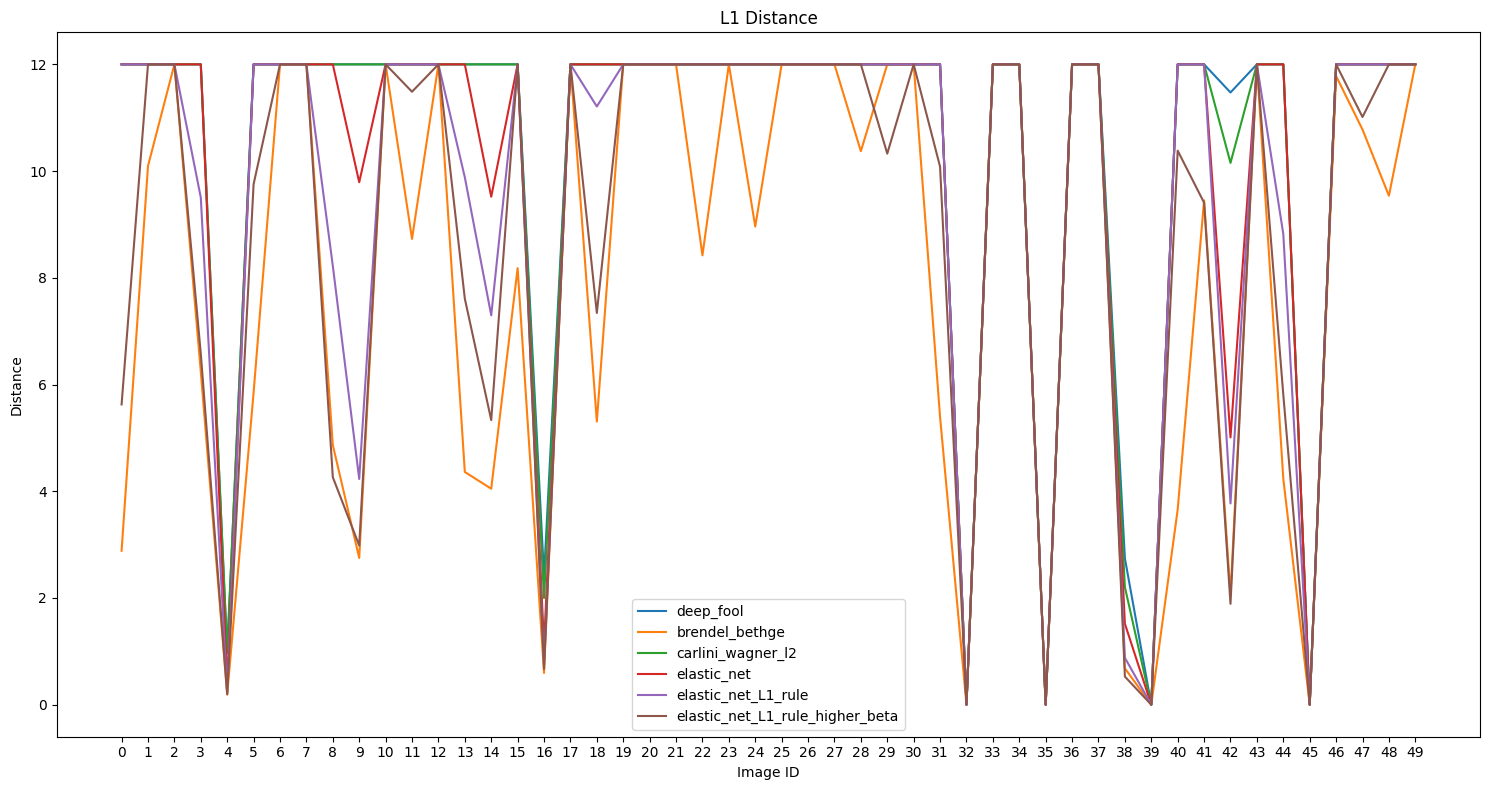

In [34]:
attack_types_with_distance = [
                'brendel_bethge', #bounded-min
                'pgd_early_stopping', #not-bounded
                'deep_fool', #not-bounded
                'carlini_wagner_l2', #not-bounded
                'elastic_net', #not-bounded
                'elastic_net_L1_rule', #not-bounded
                'elastic_net_L1_rule_higher_beta', #not-bounded
                ]

selected_attack_types_with_distance = [a for a in attack_types if a in attack_types_with_distance]

plt.figure(figsize=(15, 8))
for attack_type in selected_attack_types_with_distance:
  plt.plot(list(range(len(xtest))), results_dict[attack_type]['adversarial_distance'], label=attack_type)
plt.xlabel('Image ID')
plt.ylabel('Distance')
plt.title(f'L{norm} Distance')
plt.legend()
plt.tight_layout()
plt.xticks(list(range(len(xtest))))
plt.show()

# Runtime per image

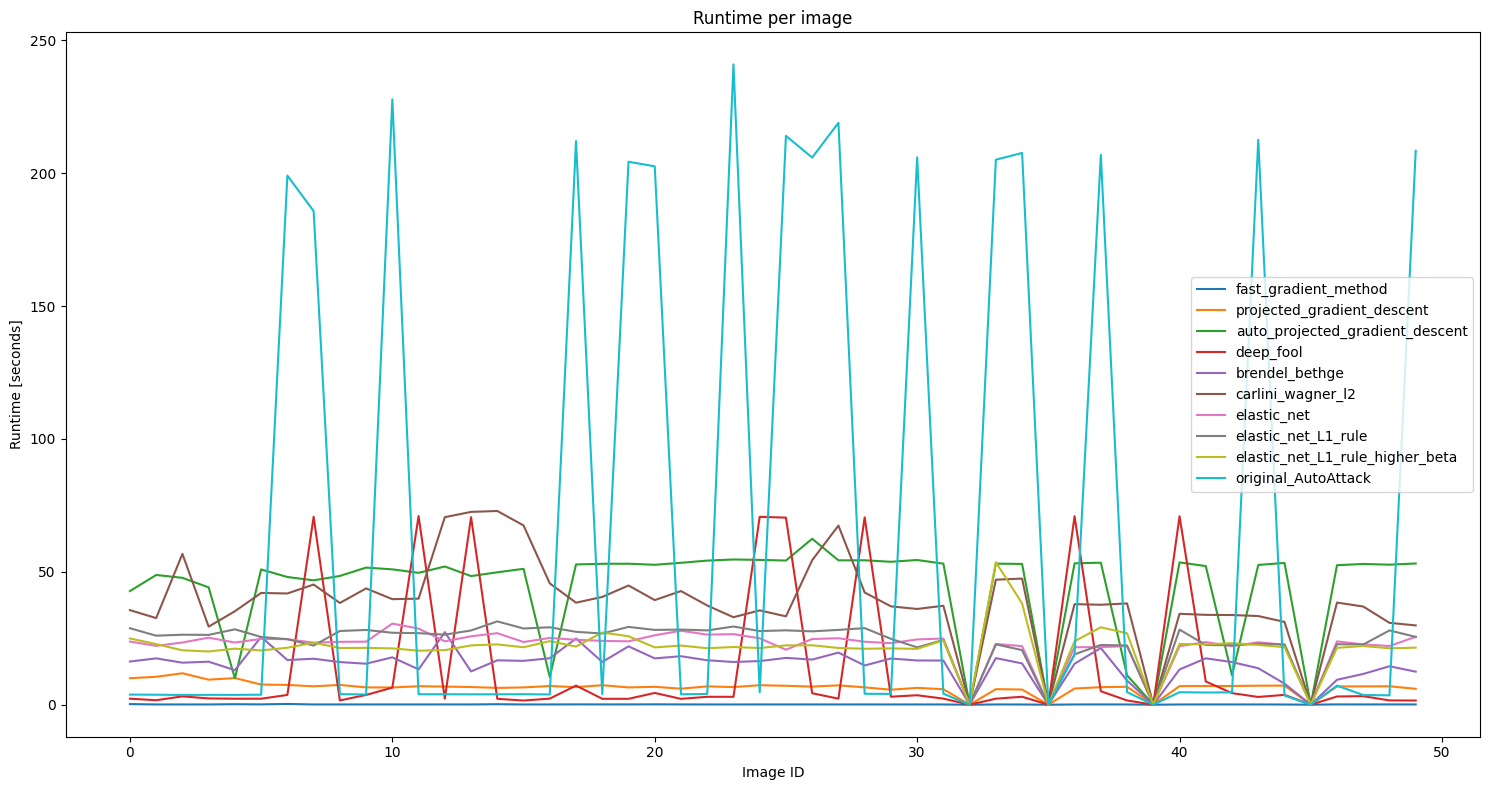

In [35]:
plt.figure(figsize=(15, 8))
for attack_type in attack_types:
  plt.plot(list(range(len(xtest))), results_dict[attack_type]['runtime'], label=attack_type)
plt.xlabel('Image ID')
plt.ylabel('Runtime [seconds]')
plt.title('Runtime per image')
plt.legend()
plt.tight_layout()
plt.show()

## Adversarial Accuracy

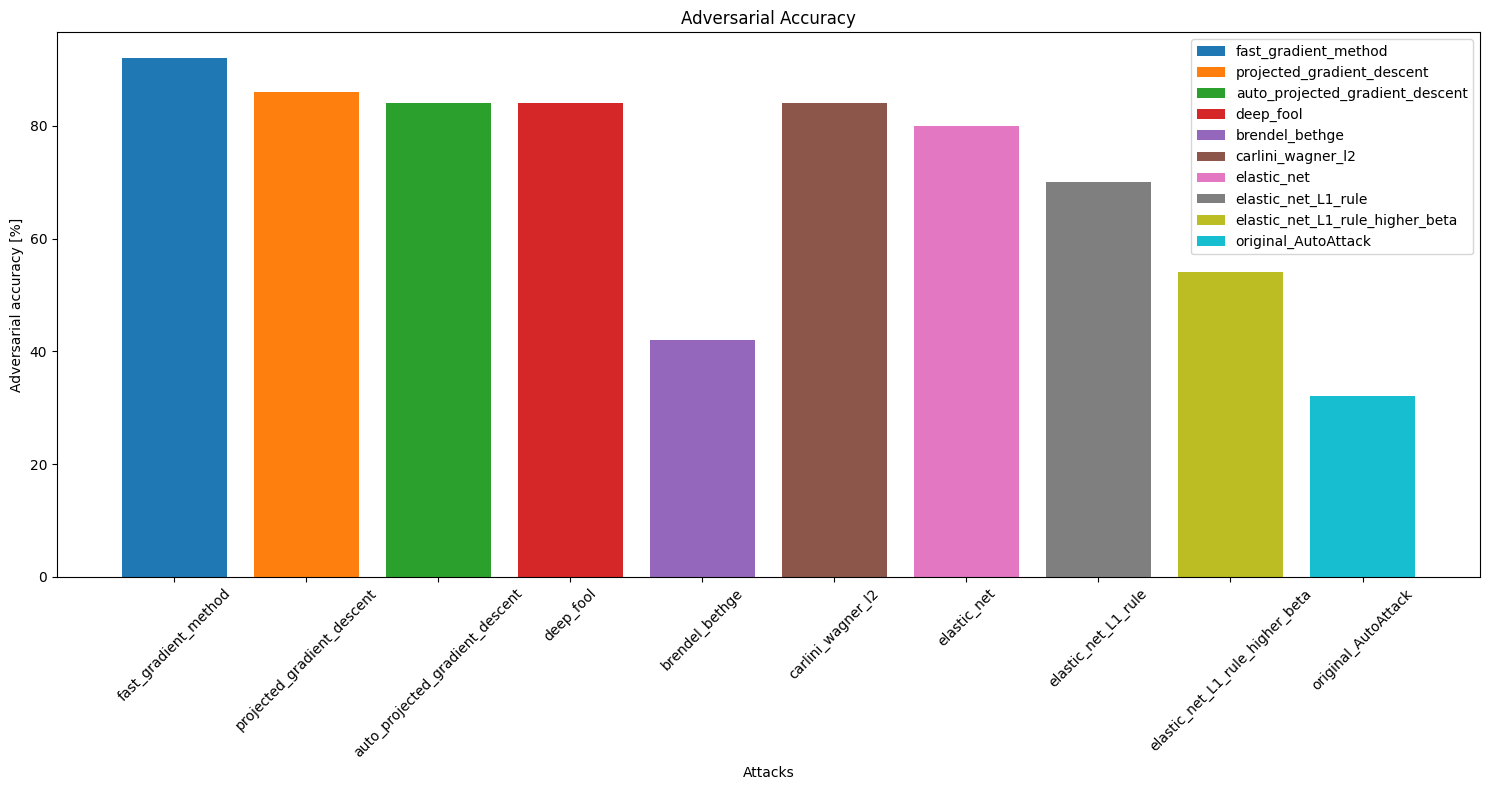

In [36]:
plt.figure(figsize=(15, 8))
for attack_type in attack_types:
  plt.bar(attack_type, results_dict[attack_type]['adversarial_accuracy'], label=attack_type)
plt.xlabel('Attacks')
plt.ylabel('Adversarial accuracy [%]')
plt.xticks(rotation=45)
plt.legend()
plt.title('Adversarial Accuracy')
plt.tight_layout()
plt.show()

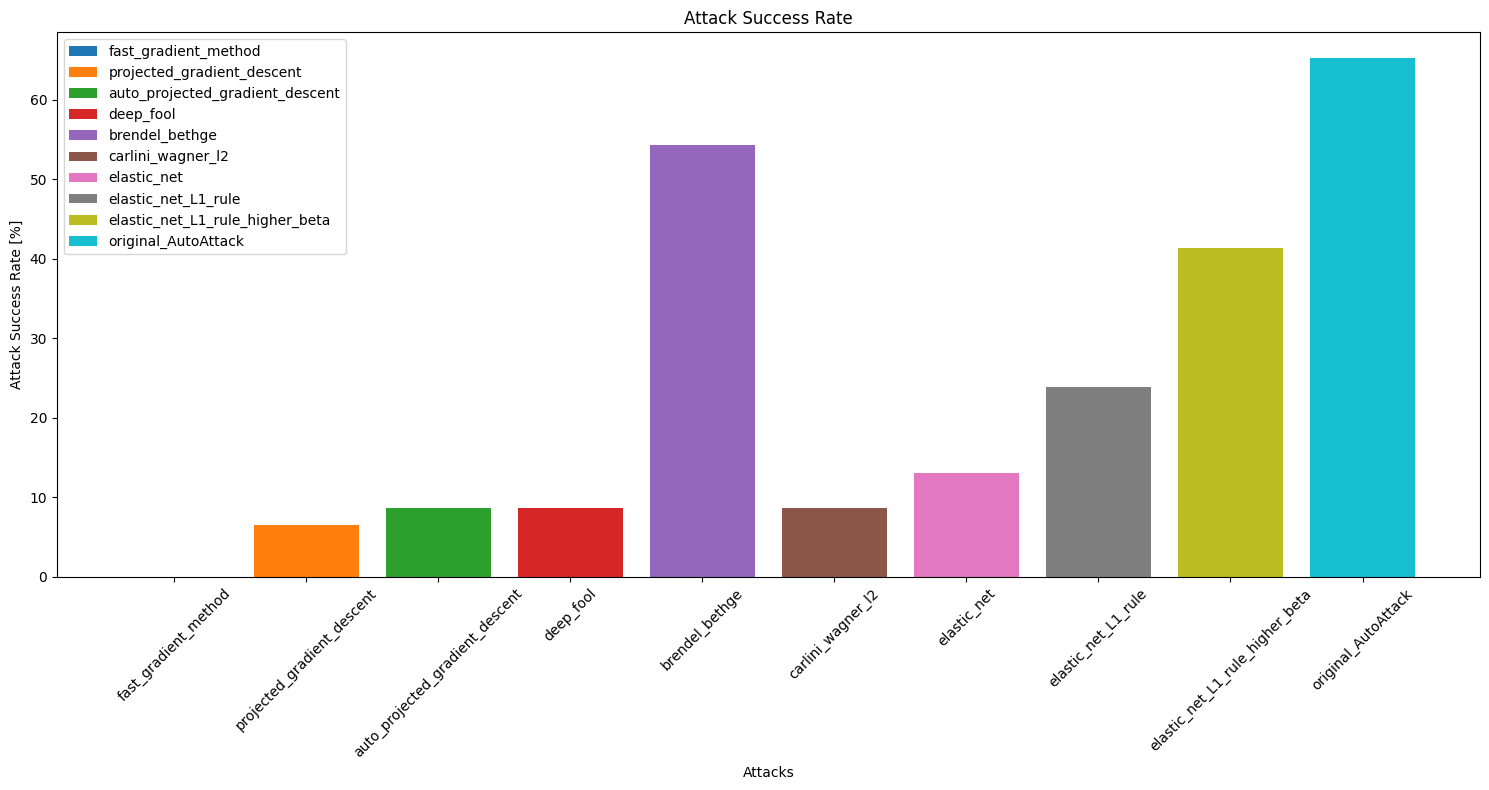

In [37]:
plt.figure(figsize=(15, 8))
for attack_type in attack_types:
  plt.bar(attack_type, results_dict[attack_type]['attack_success_rate'], label=attack_type)
plt.xlabel('Attacks')
plt.ylabel('Attack Success Rate [%]')
plt.xticks(rotation=45)
plt.legend()
plt.title('Attack Success Rate')
plt.tight_layout()
plt.show()

## Total Runtime

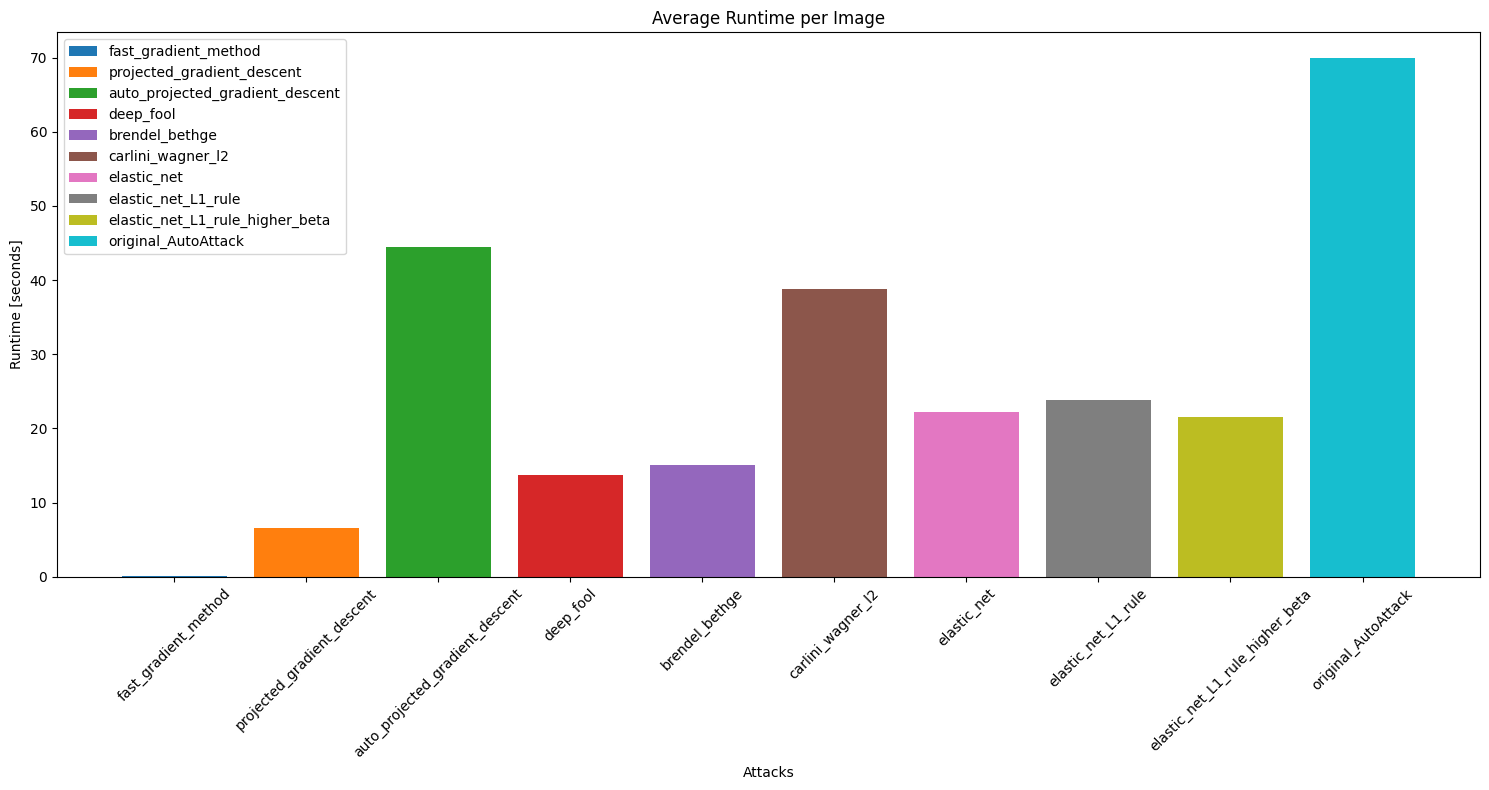

In [38]:
plt.figure(figsize=(15, 8))
for attack_type in attack_types:
  plt.bar(attack_type, sum(results_dict[attack_type]['runtime'])/splitsize, label=attack_type)
plt.xlabel('Attacks')
plt.xticks(rotation=45)
plt.ylabel('Runtime [seconds]')
plt.title('Average Runtime per Image')
plt.legend()
plt.tight_layout()
plt.show()